In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# matplotlib.use("agg")
# from scipy.signal import savgol_filter as savgol
import random

# #all imports go here
# %pylab inline
# %matplotlib inline
# #from acq400_hapi import *
# from bitarray import bitarray
# import struct

# import shelve
# import scipy.fft as Sci
# import csv

#uut = Acq400("150.203.19.68", monitor=True)
#uut = Acq400("192.168.1.4", monitor=True)        



# import math
# from bitarray import bitarray
# import struct
# import shelve
# import math
# import statistics  
# from scipy.signal import savgol_filter as savgol


#import line_profiler
#%load_ext line_profiler

import io
import itertools
import logging
import numpy
import functools
import linecache
import sys
#from .Input import *
import time
import mmap


def Trapfilter(filtered, L=200, k=5000, M=35000):
    #L=70, k=100, M=10000
    '''
    Process a HPGe detector channel.
    Note it needs positive-going pre-amp pulses for input.
    '''    
    inds = np.linspace(0, filtered.shape[-1]-1, filtered.shape[-1],dtype=int)
   # print(inds[1:-1])
   # print(len(inds))
    d = filtered[inds] - filtered[(inds-L)] - \
        filtered[(inds-k)] +\
        filtered[(inds - k - L)]
    p = np.cumsum(d)
    r = (p + M*d)/(M*L)
    #print(r)
    Trapezoid = np.cumsum(r)
    return Trapezoid
    #return np.max(Trapezoid)
    
def findenergy(eventarray):
    energyperwire = []
   # print(energyperwire)
    for i in range(10):
        #wireE = procFilter(eventarray[i],50,100,175)
        wireE = Trapfilter(eventarray[i],200,5000,35000)
        #print(wireE)
        energyperwire.append(wireE)
    return energyperwire
    #print(energyperwire)
        
def eventenergy(event):
   # print(energyperwire)
    totalE = 0
    for i in range(4):
        wireE = procFilter(event.wfms[i][0])
#                wireE = procFilter(event[i])

        totalE += wireE
    return totalE
    #print(energyperwire)
    

def procFilter(filtered, L=200, k=5000, M=35000):
    #L=70, k=100, M=10000
    '''
    Process a HPGe detector channel.
    Note it needs positive-going pre-amp pulses for input.
    '''    
    inds = np.linspace(0, filtered.shape[-1]-1, filtered.shape[-1],dtype=int)
   # print(inds[1:-1])
   # print(len(inds))
    d = filtered[inds] - filtered[(inds-L)] - \
        filtered[(inds-k)] +\
        filtered[(inds - k - L)]
    p = np.cumsum(d)
    r = (p + M*d)/(M*L)
    
    Trapezoid = np.cumsum(r)
    #return Trapezoid
    return np.max(Trapezoid)

def chanspread(wfm, ch):
    offsetdict = {1:75, 2:25, 3:-25, 4:-75}
    nuwfm = []
    for sample in wfm:
        nu = sample + offsetdict[ch]
        nuwfm.append(nu)
    return nuwfm

def plot_events(data, title):
           
    plt.figure(figsize=(20,10))
    fig, axs = plt.subplots(2, 5)
    for j in range(2):
        
        for k in range(5):
            event = random.randint(0, len(data)-1)
            datatest = data
            chans = 4
            #channel = 1
            #columns = ["RawWaveform_1", "RawWaveform_2", "RawWaveform_3", "RawWaveform_4", "RawWaveform_5", "RawWaveform_6", "RawWaveform_7", "RawWaveform_8", "RawWaveform_9", "RawWaveform_10"]
            labels = [1,2,3,4]
            #print("event is ", event)
            #print("len is ", len(wfmlist))
            no = data[event].eventnums[1]
            #print("No is ", no)
            energy = round(data[event].totalE, 3)
            
#             try:
#                 decay = round(float(objects[no].decaytime), 3)
#             except:
#                 decay = objects[no].decaytime
            wire = data[event].nowires
#             reject = objects[no].rejectevt
            
            Energylabel = "Energy:" +  str(energy)
#             DecayLabel = "Decay:" +  str(decay)
            WireLabel = "#Wires:" +  str(wire)
            
            axs[j, k].plot([], [], ' ', label=Energylabel)
#             axs[j, k].plot([], [], ' ', label=DecayLabel)
            axs[j, k].plot([], [], ' ', label=WireLabel)
#             axs[j, k].plot([], [], ' ', label=reject)
            
            first_legend = axs[j, k].legend(loc='upper right')

            axs[j, k].add_artist(first_legend)
            
            lines = []
            
            for i in range(4):
                lines += axs[j,k].plot(range(22000), chanspread(data[event].wfms[i], i+1), label=labels[i])
                
            
            #axs[j, k].legend(handles=[line2], loc='lower right')    
               
            axs[j, k].legend(handles = lines, loc="lower right")
            axs[j, k].set_title("Event " +  str(no))
                #channel += 1
                  
    plt.suptitle(title, size=30)
    plt.show()
    
def ToT(wfm, threshold):
    
    firstoverT = np.where(wfm > threshold)
    #print("Fistover t length",len(firstoverT[0]))
    if len(firstoverT[0]) != 0:
        #return firstoverT[0][0]
        # print(firstoverT[0][0])
        backoverT = np.where(wfm[firstoverT[0][0]:] < threshold)
        if len(backoverT[0]) == 0:
            #print("Maybe real?")
            return firstoverT[0][0], -1, len(firstoverT[0])
        else:
            #if backoverT[0][0] > 4:
            #    print("Backover in", backoverT[0][0])
            return firstoverT[0][0], backoverT[0][0] , len(firstoverT[0])
    else:
        return -9, -9, 0
        # ToT = backoverT[0][0]-firstoverT[0][0]
        # print(ToT)

        
def plot_traps(data, title):
           
    plt.figure(figsize(20,10))
    fig, axs = plt.subplots(2, 5)
    for j in range(2):
        
        for k in range(5):
            event = random.randint(0, len(data)-1)
            datatest = data
            chans = 4
            #channel = 1
            #columns = ["RawWaveform_1", "RawWaveform_2", "RawWaveform_3", "RawWaveform_4", "RawWaveform_5", "RawWaveform_6", "RawWaveform_7", "RawWaveform_8", "RawWaveform_9", "RawWaveform_10"]
            labels = [1,2,3,4]
            #print("event is ", event)
            #print("len is ", len(wfmlist))
            no = data[event].eventnums[1]
            #print("No is ", no)
            energy = round(data[event].totalE, 3)
            
#             try:
#                 decay = round(float(objects[no].decaytime), 3)
#             except:
#                 decay = objects[no].decaytime
            wire = data[event].nowires
#             reject = objects[no].rejectevt
            
            Energylabel = "Energy:" +  str(energy)
#             DecayLabel = "Decay:" +  str(decay)
            WireLabel = "#Wires:" +  str(wire)
            
            axs[j, k].plot([], [], ' ', label=Energylabel)
#             axs[j, k].plot([], [], ' ', label=DecayLabel)
            axs[j, k].plot([], [], ' ', label=WireLabel)
#             axs[j, k].plot([], [], ' ', label=reject)
            
            first_legend = axs[j, k].legend(loc='upper right')

            axs[j, k].add_artist(first_legend)
            
            lines = []
            
            for i in range(4):
                lines += axs[j,k].plot(range(22000), Trapfilter(data[event].wfms[i]), label=labels[i])
                
            
            #axs[j, k].legend(handles=[line2], loc='lower right')    
               
            axs[j, k].legend(handles = lines, loc="lower right")
            axs[j, k].set_title("Event " +  str(no))
                #channel += 1
                   
    plt.suptitle(title, size=30)       
    plt.show()

class Filter():
    def __init__(self):
        ...
                
    def passChecks(event):
        return True

class SetupWaveforms(Filter):
    """
    ADC to mV conversion
    """
    
    def __init__(self):
        ...
                
    def passChecks(event):
        #code goes here
        #print(type(event.wfms[0][0]))
        #print(shape(event.wfms))
        #print(event.boardID)
        #print(event.wfms)
        event.wfms = np.multiply(event.wfms, 0.48828125)
        #print(event.wfms)
        
        return True
  


class RemoveNeg(Filter):
    """
    Filter used to scrub out negative peaks caused by suspected sparking
    
    """
    
    def __init__(self):
        ...
                
    def passChecks(event):
        #code goes here
        #print(type(event.wfms[0][0]))
        #return not(sum(event.wfms[0][0] < - 10))
        #print((event.wfms))
        #print(np.min(event.wfms))
        if np.min(event.wfms) < -20:
          #  print("Failed Negative pulse")
            return False
        else:
            #print("Pass")
            return True
        # for wire in range(4): 
        #     for signal in range(len(event.wfms[0][0])):
        #         sig = event.wfms[wire][0][signal]
        #         #print(sig)
        #         if sig < -10:
        #             #print("Bad Event")
        #             return False
        #         else:
        #             ...
        #             #print("Good event")
        # return True
    
class RemoveMuons(Filter):
    """
    Filter used to scrub out muons
    
    """
    
    def __init__(self):
        ...
                
    def passChecks(event):
        #code goes here
        #print(event.wfms[0][0][0])
        nowires = 0
        for wire in range(4): 
            for signal in range(len(event.wfms[0][0])):
                sig = event.wfms[wire][0][signal]
                #print(sig)
                if sig > 10:
                    nowires += 1
                    break
                else:
                    ...
        event.nowires = nowires
        #print(nowires)            
        if nowires == 4 or nowires == 0:
            return False
        else:
            return True
    
class EnergyCut(Filter):
    """
    Filter used to scrub out muons
    
    """
    
    def __init__(self):
        ...
                
    def passChecks(event):
        #code goes here
        
        
        # for evt in range(len(data.events)):
        totalE = 0
        for i in range(4):
            event.wireE[i] = procFilter(event.wfms[i][0])
#                wireE = procFilter(event[i])

            totalE += event.wireE[i]
        
        event.totalE = totalE
            
        return True
                    
                   
        # if energy < 30:
        #     return False
        # else:
        #     return True
    
class Zoids(Filter):
    def __init__(self):
        ...
                
    def passChecks(event):
        return True
    
class FiducialCut(Filter):
    """
        
    """
    
    def __init__(self):
        ...
                
    def passChecks(event):
        #code goes here
        good = True
        
        if event.nowires == 1:
                if event.wireE[0] == 0 and event.wireE[3] == 0:
                    ...
                else:
                    return False
        
        return True

class ToTCut(Filter):
    """
        
    """
    
    def __init__(self):
        ...
                
    def passChecks(event):
        #code goes here
        for i in range(4):
            if event.wireE[i] > 0:
                wfm = event.wfms[i][0].tolist()
                #print("Wfm is ", wfm)
                peak = max(wfm)
                print("Peak is", peak)
                peakloc = wfm.index(peak)
                print("Peakloc is", peakloc)
                ToTval = peakloc + 500
                print("TOTVal is", ToTval)
                try:
                    if wfm[ToTval] < (0.2*peak) or ToTval > len(wfm):
                        print("what it is in the waveform", wfm[ToTval])
                        return False
                    else:
                        ...
                except:
                    return False
        
        for i in range(4):
            event.risetime[i] = risetime(event.wfms, i)
            event.arrivaltime[i] = arrivaltime(event.wfms, i)
        
        return True
    
class diffcut(Filter):
    def __init__(self):
        pass
    
    def passChecks(event):
        thediff = np.diff(event.wfms)
        if np.all(thediff < 2):
            return False
        else:
            return True

class Event():
    def __init__(self):
        self.recordLength = 0

        self.times = 0
        self.wfms = []
        self.eventnums = []
        self.eventSizes = 0
        
        self.savGolWaveforms = []
        self.savGolEnergy = []
        
        self.wireE = [0, 0, 0, 0]
        self.totalE = 0
        self.nowires = 0
        self.risetime = [0,0,0,0]
        self.arrivaltime = [0,0,0,0]


class Binary_analysis():
    def __init__(self, InputFiles, start, stop, step):
        self.selectedevents = range(start, stop, step)
        #print(self.selectedevents[0])
        self.events = []
        self.NumEvents = 0
        
        self.binaryStreams = []
        self.recordLength = []
        # self.times = 0
        # self.wfms = []
        # self.eventnums = []
        # self.eventSizes = []
        
        #self.binarystart = binarystart
        
        
        for InputFile in InputFiles:
            
            #print(self.selectedevents[0])
            self.binaryStreams.append(open(InputFile, "rb"))
            # self.recordLength.append(0)
            # self.NumEvents.append(0)
            # self.times.append([])
            # self.wfms.append([])
            # self.eventnums.append([])
            # self.eventSizes.append(0)
        
    
    # def checkHeader(self):
    #     for i in range(len(self.binaryStreams)):
    #         self.binaryStreams[i].seek(0)
    #         word = self.binaryStreams[i].read(4)
    #         self.eventSizes[i] = int.from_bytes(word, byteorder='little', signed=False)
           
    
    def populate_event(self):
        event = Event()
        self.events.append(event)
        event.recordLength = 0
        #event.eventnums.append([])
        #event.eventSizes.append(0)
        
        self.binaryStreams[0].seek(0)
        word = self.binaryStreams[0].read(4)
        event.eventSizes = int.from_bytes(word, byteorder='little', signed=False)


        #print(self.selectedevents[i])
        self.binaryStreams[0].seek((self.evt*event.eventSizes))
        #print("POinter is here", filePointer.tell())

        word = self.binaryStreams[0].read(4)
        #print(word)
        event.eventSizes = int.from_bytes(word, byteorder='little', signed=False)
        #print("Event size is", self.eventSize)

        event.recordLength = (event.eventSizes - 24) // 2
        #print("Record length is", self.recordLength)

        # word = self.binaryStreams[0].read(4)
        # event.boardID = int.from_bytes(word, byteorder='little', signed=False)
        # word = self.binaryStreams[0].read(4)
        # pattern = int.from_bytes(word, byteorder='little', signed=False)
        # word = self.binaryStreams[0].read(4)
        # channelNumber = int.from_bytes(word, byteorder='little', signed=False)
        
        
        for i in range(len(self.binaryStreams)):
            
            self.binaryStreams[i].seek((self.evt*event.eventSizes)+4)
            word = self.binaryStreams[i].read(4)
            event.boardID = int.from_bytes(word, byteorder='little', signed=False)
            #print(event.boardID)
            word = self.binaryStreams[i].read(4)
            pattern = int.from_bytes(word, byteorder='little', signed=False)
            word = self.binaryStreams[i].read(4)
            channelNumber = int.from_bytes(word, byteorder='little', signed=False)
            #print(channelNumber)
            word = self.binaryStreams[i].read(4)
            event.eventnums.append(int.from_bytes(word, byteorder='little', signed=False))
            word = self.binaryStreams[i].read(4)
            event.times = int.from_bytes(word, byteorder='little', signed=False)
            #print(event.times)
            #event.wfms.append([])
            waveform = numpy.fromfile(self.binaryStreams[i], dtype=numpy.dtype('<u2'), offset=0, count=event.recordLength)
            #base = self.findbaseline(waveform)
            #wave = (waveform-base)*0.48828125
            wavearray = np.array(waveform)
            event.base = np.mean(wavearray[:5000])
            #print(type(wavearray))
            event.wfms.append((wavearray-event.base))
            
        self.evt += 1
        self.evet += 1
        # if self.evt== 999:
        #     location = self.binaryStreams[i].tell()
        #     print(location)
        #     return location+4
        
        #return eventSize, recordLength, channelNumber, eventnum, ttt
    def populate_data(self):
        self.evet = 0
        self.evt = self.selectedevents[0]
        #print("Evt", self.evt)
        #print("Len selected", len(self.selectedevents))
        
        #print("Going in the first time")
        self.populate_event()
        while self.events[-1].eventSizes:
            if self.evet < len(self.selectedevents):
                try:
                    self.populate_event()
                except(ValueError):
                    print("Total Events", self.evt)
                    break
                except:
                    print("Something else has gone wrong")
            else:
                break
                
    def findbaseline(self, wave, numSamples=5000):
        sums = 0
        for i in range(numSamples):
            sums += wave[i]
        average = sums/numSamples
        return average
    
    
    def filterEvents(self, filters):
        savedEvents = []
        for i, eventNumber in enumerate(self.selectedevents):
            keep = True
            #print(i)
            for filter in filters:
                if filter.passChecks(self.events[i]):
                    keep = True
                else:
                    keep = False
                    break
            if keep == True:
                savedEvents.append(self.events[i])
        self.events = savedEvents
            

Loop number 1
7500


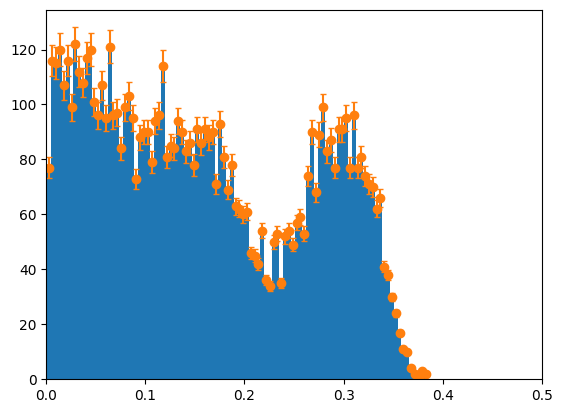

This many are above threshold 7500
There are this many when negative pulses are removed 5726
5726


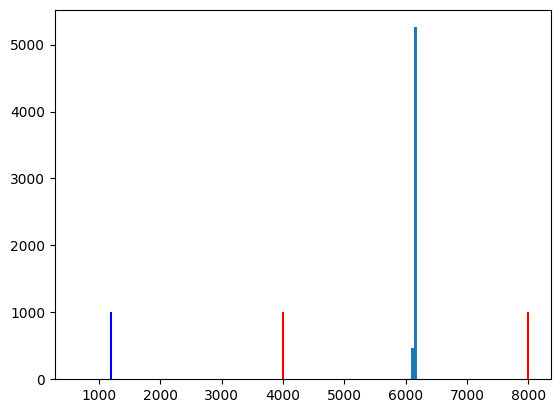

Highcut has 5726 values
Max E  434.62783203125
Min E  111.80810546875


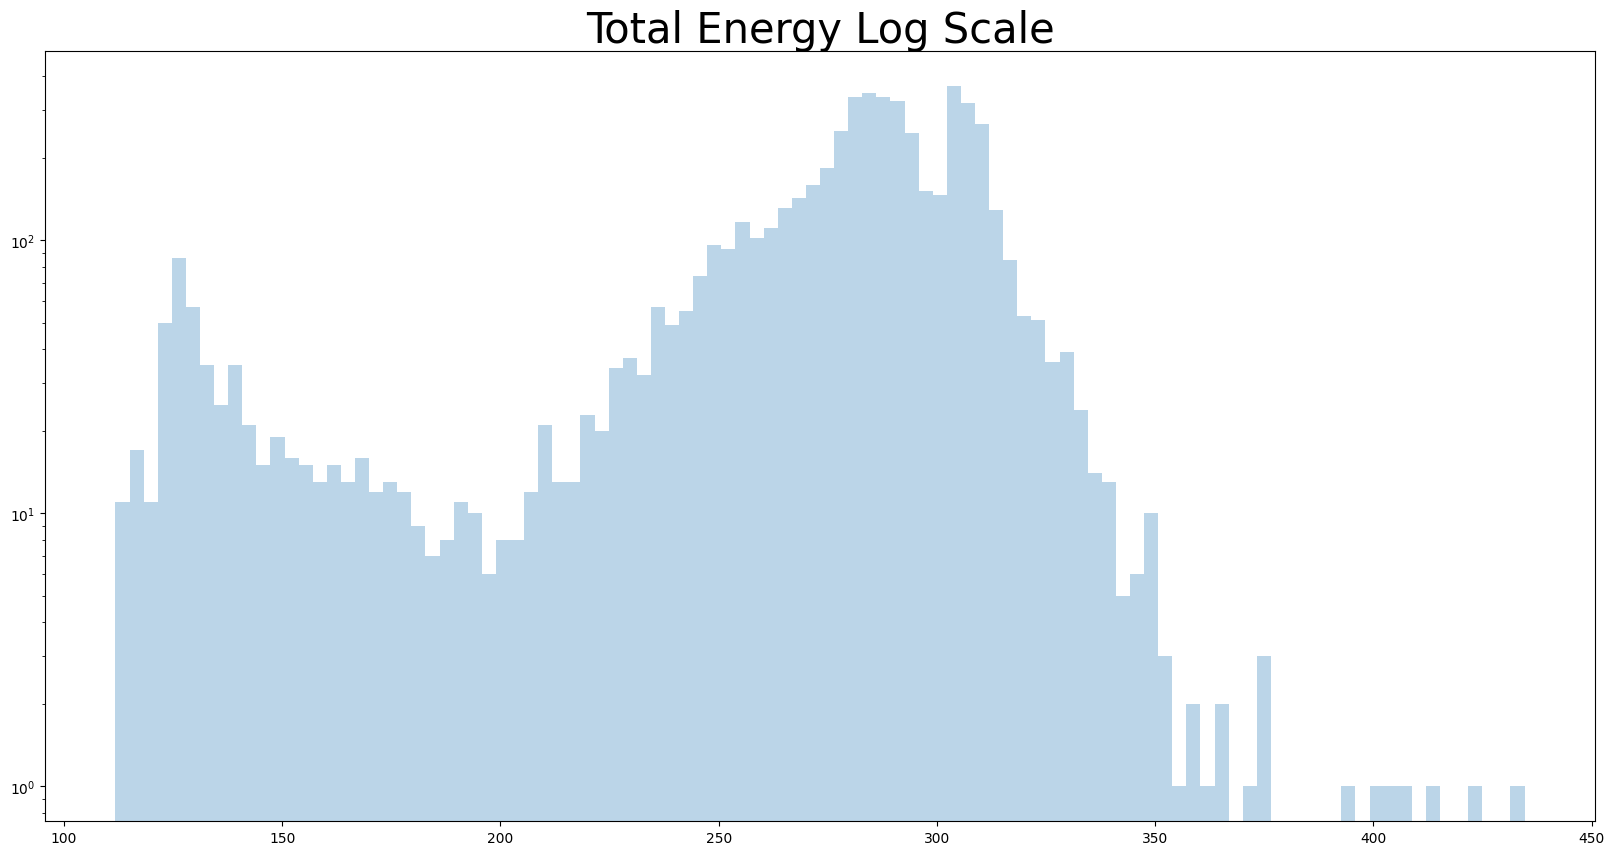

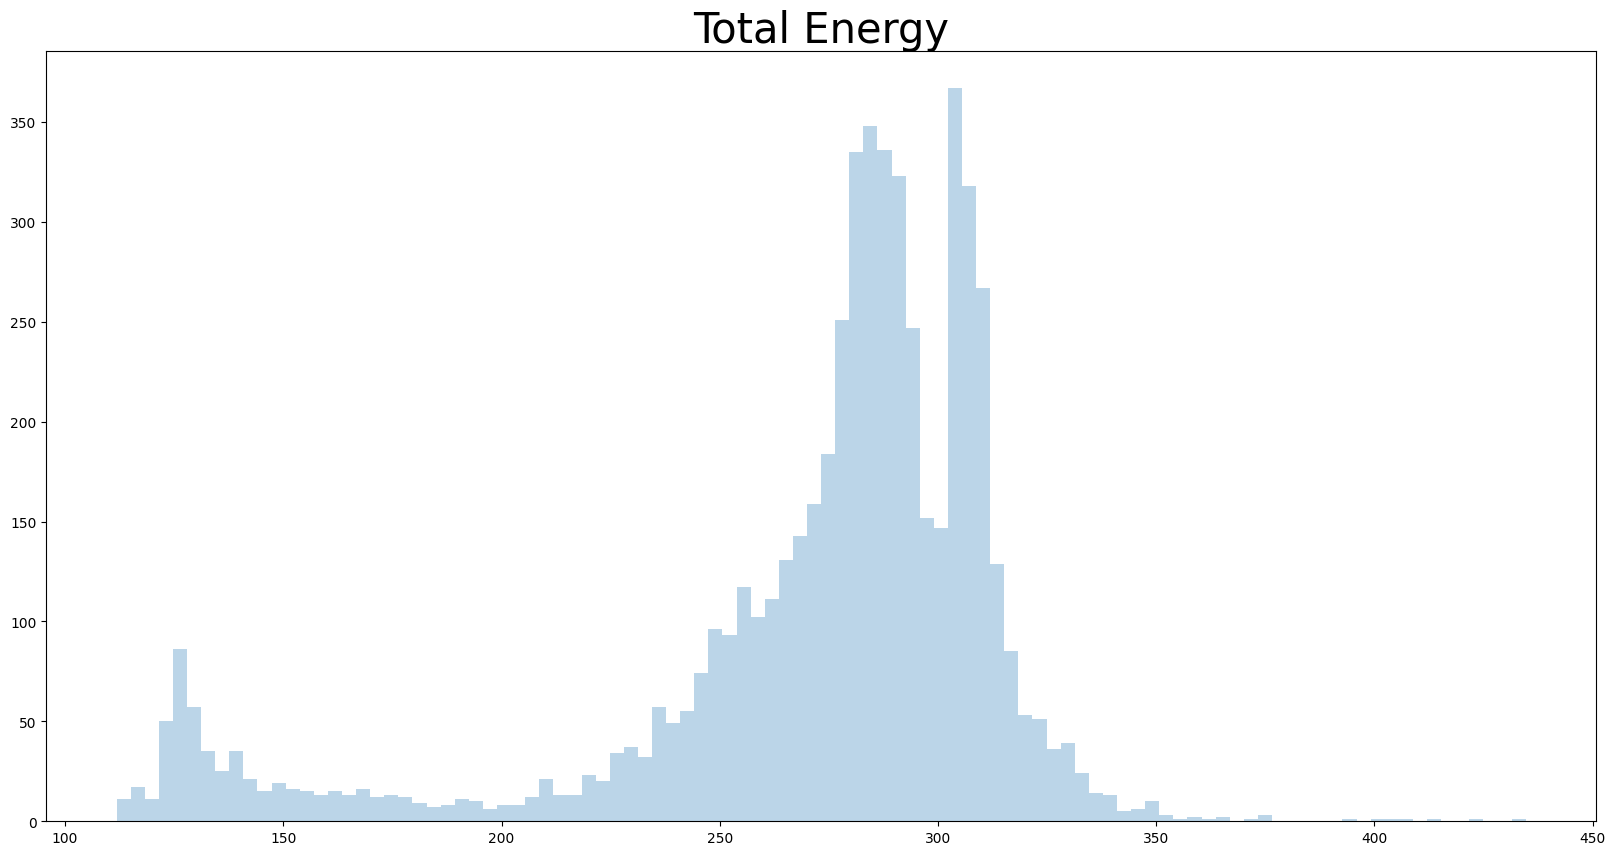

this be bins 1


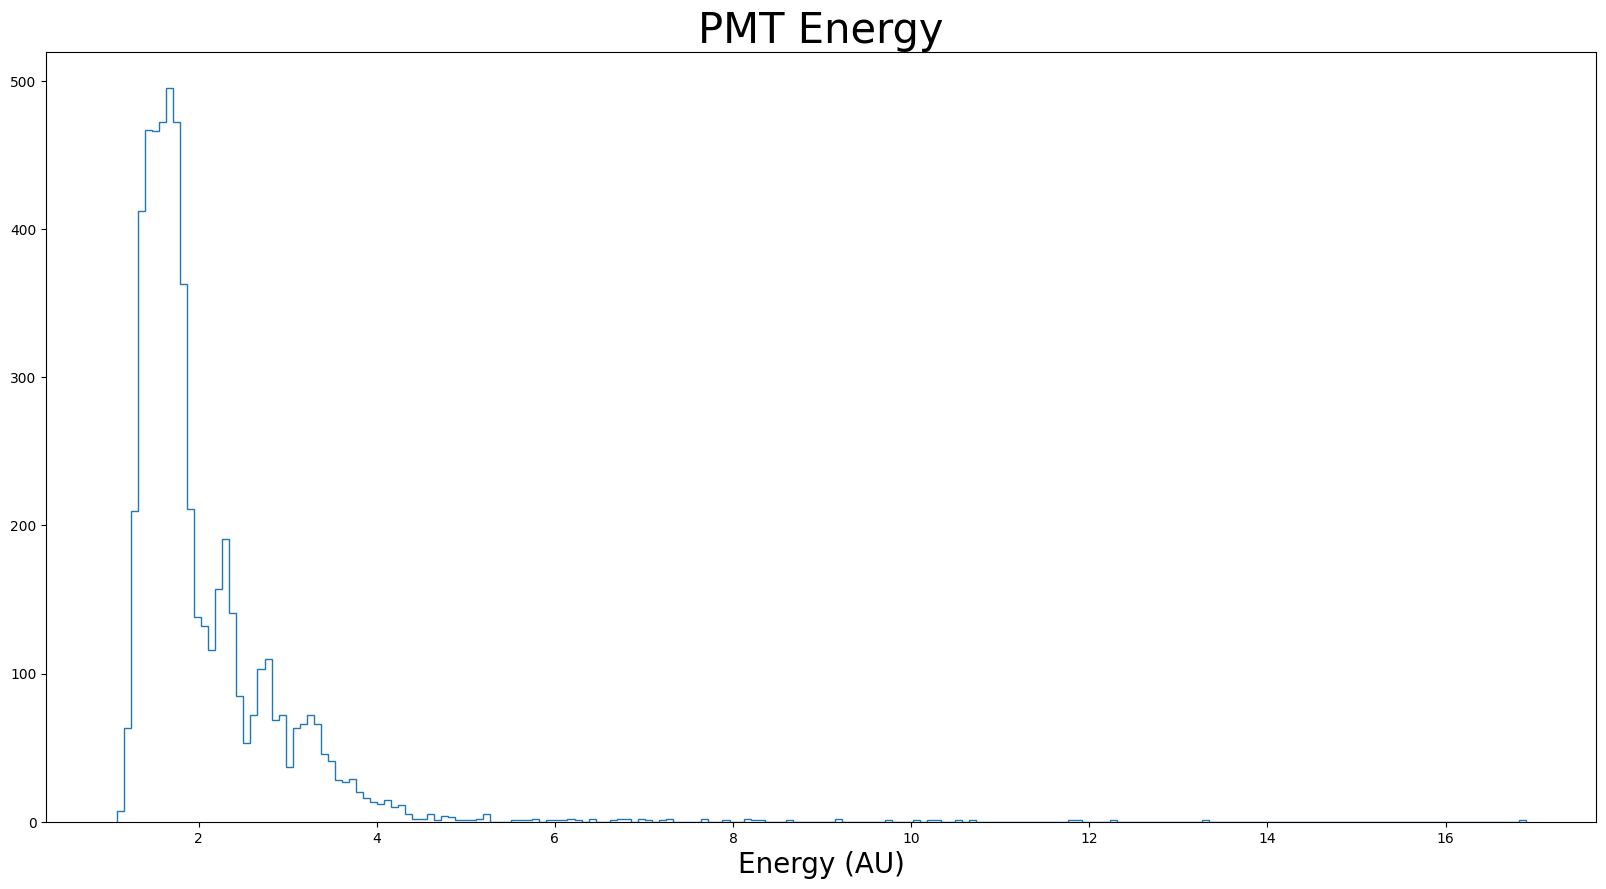

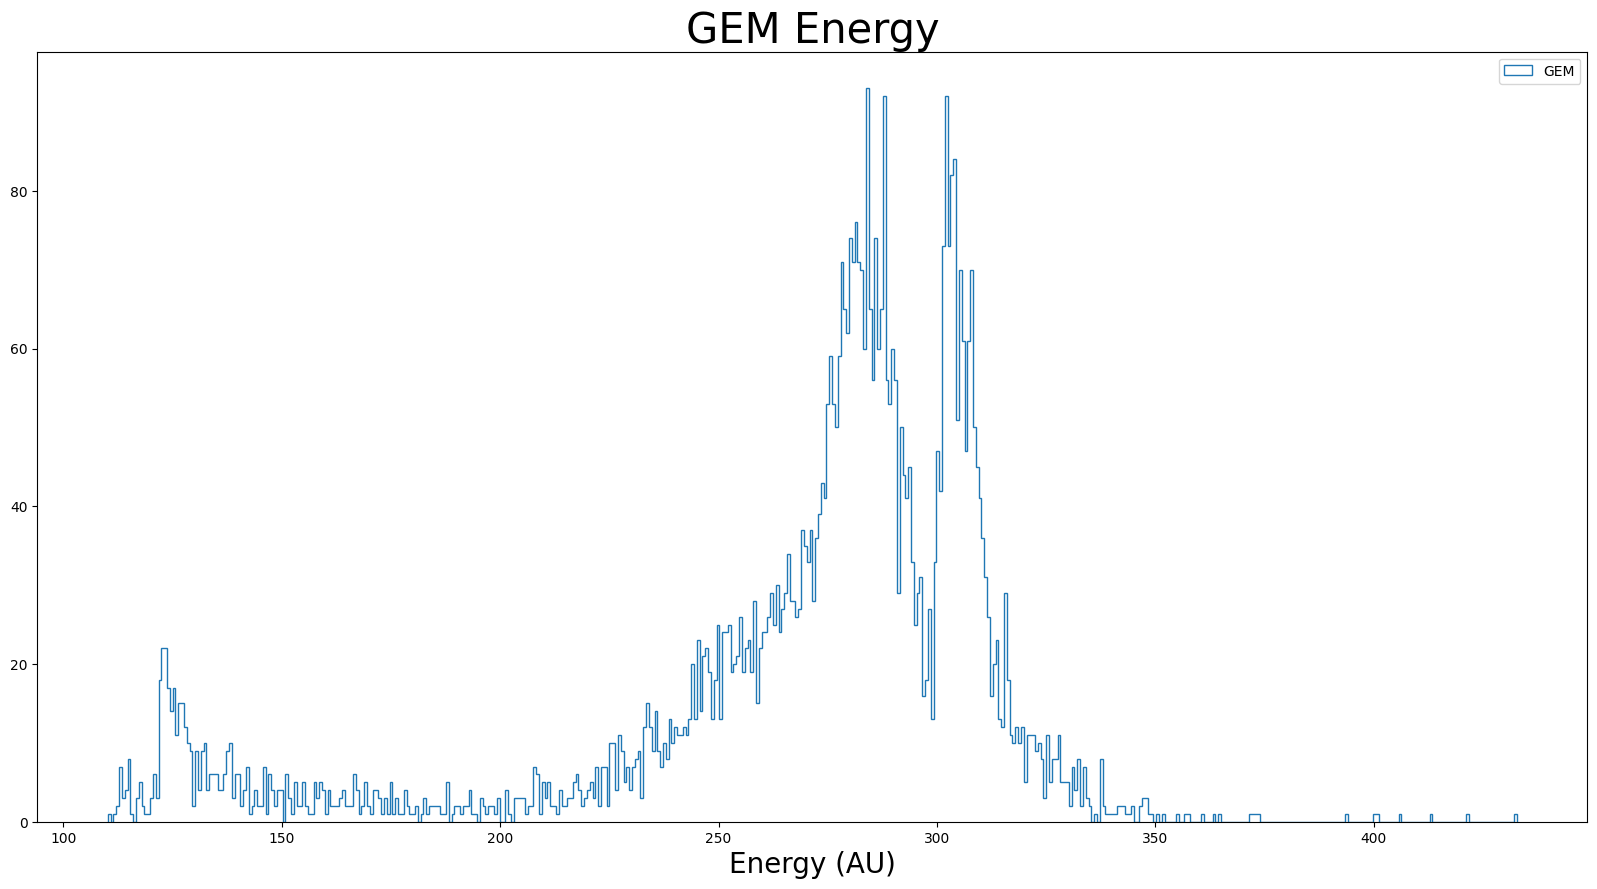

CPU times: user 8.94 s, sys: 7.64 s, total: 16.6 s
Wall time: 21.6 s


In [11]:
%%time
gas_comp = '70_30'
for k in range(1):
    
    filedate = '080323'

    voltage = 1200
    indvolt = 1000

    est_samples = 1500
    loopno = k
    #location = 0
    skipevts = 0

    wave0 = filedate + "_Charge+Optical_ThickGEM/"+ str(voltage) + "V_atten/wave0.dat"

    wave1 = filedate + "_Charge+Optical_ThickGEM/"+ str(voltage) + "V_atten/wave1.dat"

    #wave2 = "../Analysis/" + filedate + "_Charge+Optical_ThickGEM/PMT_"+ str(voltage) + "V"/wave2.dat"

    #wave3 = "../Analysis/" + filedate + "_ThickGEM_"+ str(voltage) + "V_" + str(indvolt) + "Vind_50thresh_atten_Cf_noexternalAm_wire3notconnected_increasedgain1and2/wave3.dat"

    events = []

    for i in range(5):

        if i % 10 == 1:

            print(f'Loop number {i}')

        data = Binary_analysis([wave0, wave1],

                               ((5*est_samples*loopno)+ i*est_samples + skipevts), ((5*est_samples*loopno)+ i*est_samples + skipevts)+est_samples, 1)

        # data.checkHeader()

        data.populate_data()

        data.filterEvents([SetupWaveforms])#, RemoveNeg])#, RemoveMuons, EnergyCut, FiducialCut])#, ToTCut])

        events.append(data.events)


    #%%time
    rawdata = []
    for chunk in range(len(events)):
        for event in range(len(events[chunk])):
            #maxdif.append(np.max(abs(np.diff(events[chunk][event].wfms))))
            rawdata.append(events[chunk][event])

    print(len(rawdata))

    # for evt in rawdata:
    #     evt.diff=[0,0,0,0]
    #     for i in range(4):
    #         diff = np.max(abs(np.diff(evt.wfms[i])))
    #         #print(diff)
    #         evt.diff[i] = diff

#     print("got at least to here")
#     for evt in range(len(rawdata)):

#         for i in range(4):
#             if i == 0:
#                 ...
#     #             for sample in rawdata[evt].wfms[i]:
#     #                 rawdata[evt].wfms[i][sample] = rawdata[evt].wfms[i][sample]
#             elif i == 1:
#                 rawdata[evt].wfms[i] = rawdata[evt].wfms[i]*(2.5/2.3)

#             elif i == 2:
#                 rawdata[evt].wfms[i] = rawdata[evt].wfms[i]*(2.5/3)
#             elif i == 3:
#                 rawdata[evt].wfms[i] = rawdata[evt].wfms[i]*(2.5/5)
#             else:
#                 print("Something went wrong")


    for evt in rawdata:
        trigidx = np.zeros(2, dtype=np.int32)
        fallidx = np.zeros(2, dtype=np.int32)
        Nabovethresh = np.zeros(2, dtype=np.int32)
        for i in range(2):
            trigidx[i], fallidx[i], Nabovethresh[i] = ToT(evt.wfms[i], 10)
        evt.trigidx = trigidx
        evt.fallidx = fallidx
        evt.Nabovethresh = Nabovethresh

    timesbetween = []
    for i in range(len(rawdata)):
        if i != 0:
            time = rawdata[i].times - rawdata[i-1].times
            #print(time)
            if time > 0:
                timesbetween.append(time*8E-9)
        else:
            time = rawdata[i].times
            timesbetween.append(time*8E-9)
    #print(timesbetween)
    average = 1/(sum(timesbetween)/len(timesbetween))
    #print(average)
    freq = []
    for time in timesbetween:
        freq.append(1/time)

    bins = 100

    bin_counts, bin_edges, patches = plt.hist(timesbetween, bins=bins)

    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2



    #bin_counts = np.delete(bin_counts, 0)

    #bin_centres = np.delete(bin_centres, 0)

    y_error = bin_counts/20

    plt.errorbar(x=bin_centres, y=bin_counts,

                 yerr=y_error, fmt='o', capsize=2)

    #plt.hist(freq, bins=10)

    plt.xlim(0,0.5)

    #plt.ylim(0,15)

    plt.show()
    
    '''
    #import uncertainties
    from scipy.optimize import curve_fit
    from uncertainties import ufloat

    x = bin_centres
    y = bin_counts

    a_guess = 5
    b_guess = -0.6
    c_guess = 40

    # Fit the function a * np.exp(b * t) + c to x and y
    popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, x, y, p0=(a_guess, b_guess, c_guess))

    a = popt[0]
    b = popt[1]
    c = popt[2]

    x_fitted = np.linspace(np.min(x), np.max(x), 100)
    y_fitted = a * np.exp(b * x_fitted) + c

    av = ufloat(1/(-b), 1/(b**2))

    print("Average is ", av)
    print("Variance is ", 1/(b**2))
    print("Trigger rate is", 1/av, "Hz")
    #print("With a variance of", 1/(1/(b**2)))

    plt.plot(bin_centres, bin_counts, 'o', label="data")
    plt.plot(x_fitted, y_fitted, label="fit")
    plt.vlines(0.005,0,250)
    plt.legend()
    plt.show()
    '''
    
    # linetowrite = str(voltage) + "," + str(1/av) + "," + str(av) + "," + str(est_samples) + "," + str(bins) + "\n"

    # f = open('voltage_tests.csv','a')
    # f.write(linetowrite) #Give your csv text here.
    # ## Python will convert \n to os.linesep
    # f.close()

    abovethresh = []
    for events in range(len(rawdata)):
        highest = 0
        saved = False
        for channel in range(2):
            wireheight = np.max(rawdata[events].wfms[channel])
            if wireheight > 10:
                if wireheight > highest:
                    highest = wireheight
                    rawdata[events].highwire = channel
                if saved == False: 
                    abovethresh.append(rawdata[events])
                    saved = True
            else:
                ...

    print("This many are above threshold " + str(len(abovethresh)))

    highfirst = []
    negfirst = []
    for events in range(len(abovethresh)):
        low = False
        #saved = False
        #if 101725
        #print(events)
        pmtsig = np.where(abovethresh[events].wfms[0] == np.min(abovethresh[events].wfms[0]))
        gemlow = np.where(abovethresh[events].wfms[1] == np.min(abovethresh[events].wfms[1]))
        gemhigh = np.where(abovethresh[events].wfms[1] == np.max(abovethresh[events].wfms[1]))
        #gemhigh = 1
    
        if int(pmtsig[0][0]) < int(gemhigh[0][0]):
            if gemhigh[0][0] < gemlow[0][0]:
                highfirst.append(abovethresh[events])
            else:
                negfirst.append(abovethresh[events])

        else:
            ...


    print("There are this many when negative pulses are removed " + str(len(highfirst)))

    # for j in range(25):
    #     for i in range(4):
    #         plt.plot(range(22000), negatives[j].wfms[i], label = str(i))
    #     plt.title(negatives[j].eventnums[0])
    #     plt.legend()
    #     plt.show()

    # plot_events(abovethresh, "Real?")
    # print(plt.show())

    hightimes = []
    for event in highfirst:
        hightimes.append(event.trigidx[event.highwire])
        event.hightime = event.trigidx[event.highwire]
    print(len(hightimes))

    plt.hist(hightimes, bins=100)
    plt.vlines(4000, 0,1000, 'r')
    plt.vlines(8000, 0,1000, 'r')
    plt.vlines(1200, 0,1000, 'b')
    plt.show()

    highcut = highfirst
#     midcut = []
#     lowcut = []
#     for event in removednegatives:
#         if event.hightime > 4000 and event.hightime < 8000:
#             highcut.append(event)
#         elif event.hightime > 1200 and event.hightime < 4000:
#             midcut.append(event)
#         elif event.hightime < 1200:
#             lowcut.append(event)
    print("Highcut has",len(highcut),"values")

    # plot_events(lowcut, "Very Early trigger")
    # plot_events(midcut, "early trigger")
    # plot_events(highcut, "Sweet spot")

    # plt.plot(range(22000), rawdata[1446].wfms[0], label='0')
    # plt.plot(range(22000), rawdata[1446].wfms[1], label='1')
    # plt.plot(range(22000), rawdata[1446].wfms[2], label='2')
    # plt.plot(range(22000), rawdata[1446].wfms[3], label='3')
    # plt.legend()
    # plt.show()
    # print(rawdata[1446].hightime)
    # print(rawdata[1446].trigidx)
    # print(rawdata[1446].highwire)

    # energies2 = []
    # W1 = []
    # W2 = []
    # W3 = []
    # W4 = []

    # thresh = 20

    # for evt in removednegatives:
    #         first = np.max(evt.wfms[0])
    #         if first > thresh:
    #             W1.append(first)
    #         second = np.max(evt.wfms[1])
    #         if second > thresh:
    #             W2.append(second)
    #         third = np.max(evt.wfms[2])
    #         if third > thresh:
    #             W3.append(third)
    #         fourth = np.max(evt.wfms[3])
    #         if fourth > thresh:
    #             W4.append(fourth)

    #         energy = first + second + third + fourth
    #         energies2.append(energy)
    #         evt.totalE = energy

    # cut = 1100
    # belowenergycut = []
    # aboveenergycut = []
    # for evt in abovethresh:
    #     if evt.totalE > cut:
    #         aboveenergycut.append(evt)
    #     else: 
    #         belowenergycut.append(evt)

    # #print(len(belowenergycut))
    # #print(len(aboveenergycut))
    # plt.hist(energies2, alpha=0.3, bins=100)
    # plt.hist(W1, bins=100, label='Ch4', histtype='step')
    # #plt.hist(W2, bins=100, label='Ch5', histtype='step')
    # #plt.hist(W3, bins=100, label='Ch6', histtype='step')
    # #plt.hist(W4, bins=100, label='Ch7', histtype='step')
    # plt.xlim(-10,2000)
    # plt.vlines(cut, 0, 50, colors='r')
    # plt.xlabel("Energy (AU)", size=20)
    # #plt.savefig("Spectra_newconfig_Am_saturation.png")
    # plt.legend()
    # plt.show()
    # plot_events(belowenergycut, "Below Energycut")
    # plot_events(aboveenergycut, "Above Energycut")
    # # plot_traps(belowenergycut, "Below Energy traps")
    # # plot_traps(aboveenergycut, "Above Energy traps")

    energies2 = []
    PMT = []
    GEM = []
#     W6 = []
#     W7 = []

    singles = []
    doubles = []
#     triples = []
#     quads = []

    singlesE = []
    doublesE = []
#     triplesE = []
#     quadsE = []

    thresh = 10

    for evt in highcut:
            N = 0
            first = np.min(evt.wfms[0])
            if -first > thresh/10:
                N += 1
                PMT.append(-first)

            second = np.max(evt.wfms[1])
            if second > thresh:
                N += 1
                GEM.append(second)

#             third = np.max(evt.wfms[2])
#             if third > thresh:
#                 N += 1
#                 W6.append(third)

#             fourth = np.max(evt.wfms[3])
#             if fourth > thresh:
#                 N += 1
#                 W7.append(fourth)

            energy = -first + second
            energies2.append(energy)
            evt.totalE = energy

            if N == 1:
                singles.append(evt)
                singlesE.append(energy)
            elif N == 2:
                doubles.append(evt)
                doublesE.append(energy)
#             elif N == 3:
#                 triples.append(evt)
#                 triplesE.append(energy)
#             elif N == 4:
#                 quads.append(evt)
#                 quadsE.append(energy)
            else:
                ...

    #print(len(doubles))
    # cut = 150
    # belowenergycut = []
    # aboveenergycut = []
    # for evt in highcut:
    #     if evt.totalE > cut:
    #         aboveenergycut.append(evt)
    #     else: 
    #         belowenergycut.append(evt)

    #print(len(belowenergycut))
    #print(len(aboveenergycut))
    print("Max E ", max(energies2))
    print("Min E ", min(energies2))
    plt.figure(figsize=(20,10))
    binwidth = int(int(max(energies2)-min(energies2))/200)
    plt.hist(energies2, alpha=0.3, bins=100, label="Total")
    plt.yscale('log')
    plt.title("Total Energy Log Scale", size=30)
    plt.show()
    plt.figure(figsize=(20,10))
    binwidth = int(int(max(energies2)-min(energies2))/200)
    plt.hist(energies2, alpha=0.3, bins=100, label="Total")
    #plt.yscale('log')
    plt.title("Total Energy", size=30)
    plt.show()
    
    plt.figure(figsize=(20,10))
    #binwidth = int(int(max(energies2)-min(energies2))/200)
    print("this be bins", binwidth)
    #plt.hist(energies2, alpha=0.3, bins=100, label="Total")
    plt.hist(PMT, bins=200, label='PMT', histtype='step')
    plt.xlabel("Energy (AU)", size=20)
    plt.title("PMT Energy",size=30)
    plt.savefig("PMT_energy_positivefirst.png")
    plt.show()
    
    plt.figure(figsize=(20,10))
    plt.hist(GEM, bins=500, label='GEM', histtype='step')
#     plt.hist(W6, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch5', histtype='step')
#     plt.hist(W7, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch6', histtype='step')
    #plt.xlim(-10,200)
    #plt.ylim(0,200)
    #plt.yscale('log')
    #plt.vlines(cut, 0, 10, colors='r')
    plt.xlabel("Energy (AU)", size=20)
    #plt.savefig("Spectra_newconfig_Am_saturation.png")
    plt.title("GEM Energy",size=30)
    plt.legend()
    plt.savefig("GEM_energy_positivefirst.png")
    plt.show()
    # plot_events(belowenergycut, "Below Energycut")
    # plot_events(aboveenergycut, "Above Energycut")
    # # plot_traps(belowenergycut, "Below Energy traps")
    # # plot_traps(aboveenergycut, "Above Energy traps")



    # import scipy.stats as sps

    # x = linspace(0, 1, int(np.max(W1)))
    # print(len(x))
    # d1 = sps.norm(0, 10)
    # d2 = sps.norm(60, 15)

    # y1 = d1.rvs(300)
    # y2 = d2.rvs(200)
    # ys = np.concatenate([y1, y2])
    # plt.hist(W1, bins=100, label='Ch4', histtype='step', density=True)
    # plt.plot(x, d1.pdf(x) * (len(y1) / len(ys)), color='C0', ls='--', label='d1')
    # plt.show()

#     plt.figure(figsize=(20,10))
#     plt.hist(singlesE, bins=100, label='singles', histtype='step')
#     plt.hist(doublesE, bins=100, label='doubles', histtype='step')
#     plt.hist(triplesE, bins=100, label='triples', histtype='step')
#     plt.hist(quadsE, bins=100, label='quads', histtype='step')
#     #plt.yscale('log')
#     plt.legend()
#     plt.show()

    # plot_events(singles, "Singles")
    # plot_events(doubles, "Doubles")
    # plot_events(triples, "Triples")
    # plot_events(quads, "Quads")



    # bins = 100
    # bin_counts, bin_edges, patches = plt.hist(doublesE, bins=bins)
    # bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

    # # y_error = bin_counts/20
    # # plt.errorbar(x=bin_centres, y=bin_counts,
    # #              yerr=y_error, fmt='o', capsize=2)
    # #plt.hist(freq, bins=10)
    # #plt.xlim(-0.5,1)
    # #plt.ylim(0,15)

    # plt.show()

    # linetowrite = str(energies2) + "," + str(singlesE) + "," + str(doublesE) + "," + str(triplesE) + "," + str(quadsE) + "\n"
    # # print(linetowrite)
    # f = open('460.csv','a')
    # f.write(linetowrite) #Give your csv text here.
    # ## Python will convert \n to os.linesep
    # f.close()




#     print("At pickle part")
#     import pickle
#     file = open('changing_voltages', 'rb')
#     data = pickle.load(file)
#     print("Supposedly loaded")
#     # open a file, where you ant to store the data
# #     file = open('changing_voltages', 'wb')
#     filename = "../Analysis/"+ gas_comp
#     file = open(filename, 'wb')
#     print("attempting to write")
#     data[0].insert(0, W4)
#     data[1].insert(0, W5)
#     data[2].insert(0, W6)
#     data[3].insert(0, W7)
#     data[4].insert(0, energies2)
#     # dump information to that file
#     pickle.dump(data, file)

#     # close the file
#     file.close()


In [ ]:
plt.figure(figsize=(20,10))
binwidth = int(int(max(energies2)-min(energies2))/200)
plt.hist(energies2, alpha=0.3, bins=100, label="Total")
plt.yscale('log')
plt.title("Total Energy Log Scale", size=30)
#plt.savefig("Energy_logscale.png")
plt.show()
plt.figure(figsize=(20,10))
binwidth = int(int(max(energies2)-min(energies2))/200)
plt.hist(energies2, alpha=0.3, bins=100, label="Total")
#plt.yscale('log')
plt.title("Total Energy", size=30)
#plt.savefig("TotalEnergy.png")
plt.show()
plt.figure(figsize=(20,10))
binwidth = int(int(max(energies2)-min(energies2))/200)
print("this be bins", binwidth)
#plt.hist(energies2, alpha=0.3, bins=100, label="Total")
plt.hist(W4, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch3', histtype='step')
plt.hist(W5, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch4', histtype='step')
plt.hist(W6, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch5', histtype='step')
plt.hist(W7, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch6', histtype='step')
plt.xlim(-10,200)
#plt.ylim(0,200)
#plt.yscale('log')
#plt.vlines(cut, 0, 10, colors='r')
plt.xlabel("Energy (AU)", size=20)
#plt.savefig("Energy_per_wire_with_attenuation.png")
plt.title(str(voltage),size=30)
plt.legend()
plt.show()

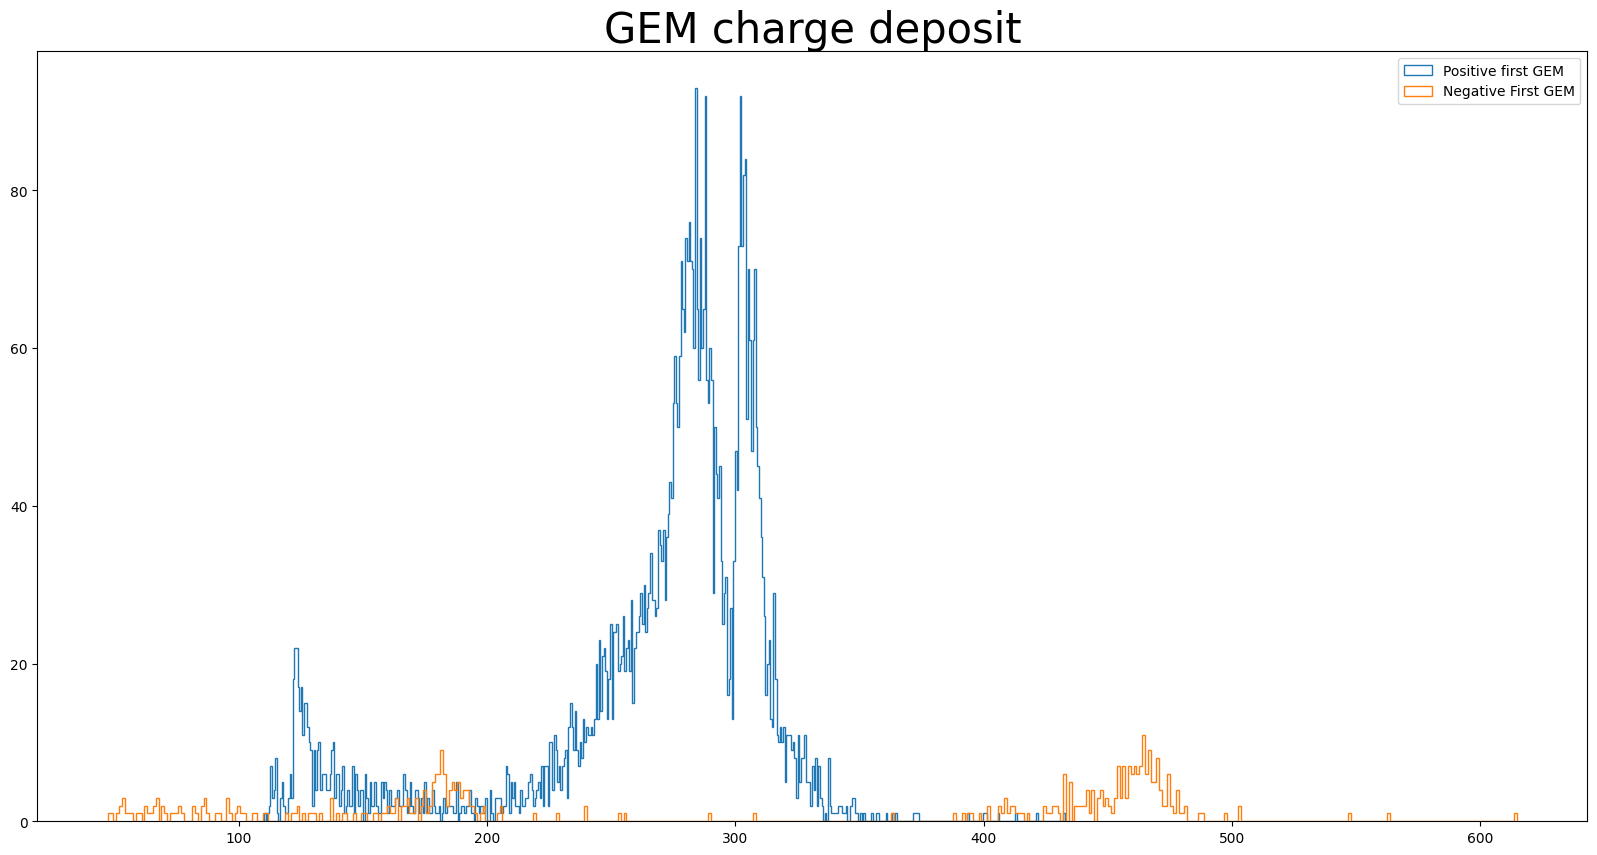

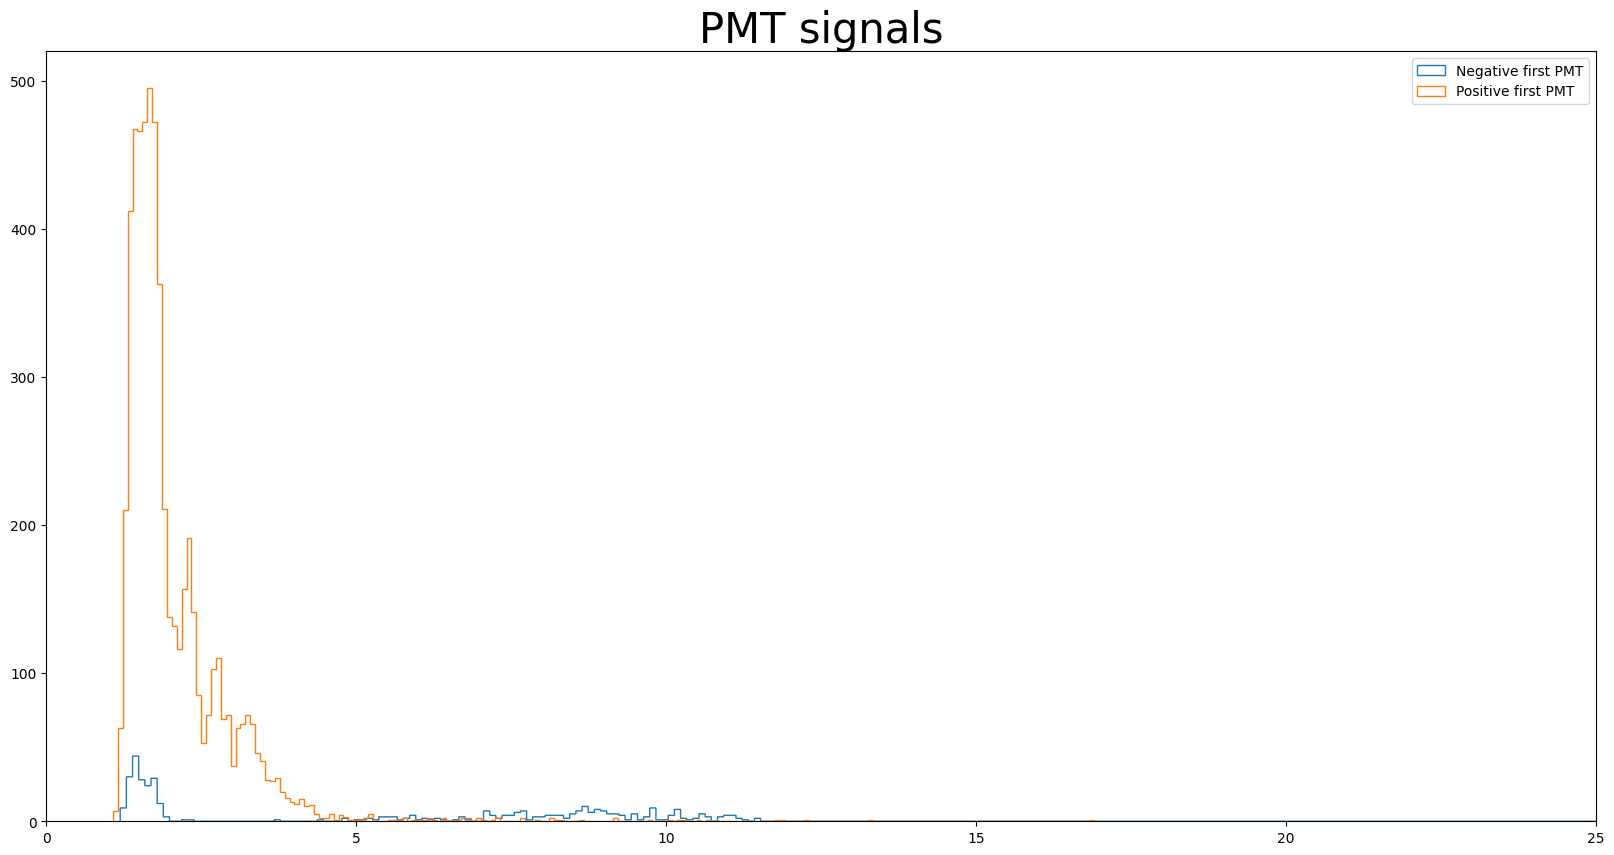

In [24]:
# negPMT = PMT
# negGEM = GEM
plt.figure(figsize=(20,10))
plt.hist(GEM, bins=500, label='Positive first GEM', histtype='step')
plt.hist(negGEM, bins=500, label='Negative First GEM', histtype='step')
plt.legend()
plt.title("GEM charge deposit", size=30)
plt.savefig("GEM_comparison.png")
plt.show()

plt.figure(figsize=(20,10))


plt.hist(negPMT, bins=2000, label='Negative first PMT', histtype='step')
plt.hist(PMT, bins=200, label='Positive first PMT', histtype='step')
plt.legend()
plt.xlim(0,25)
plt.title("PMT signals", size=30)
plt.savefig("PMT_comparison.png")
plt.show()

In [ ]:
# W4560 = W4
# W5560 = W5
# W6560 = W6
# W7560 = W7
# E560 = energies2
plt.figure(figsize=(20,10))
binwidth = int(int(max(energies2)-min(energies2))/1000)
#plt.hist(energies2, alpha=0.3, bins=100, label="Total")
# plt.hist(W4460, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch4_460', histtype='step')
# plt.hist(W4480, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch4_480', histtype='step')
# plt.hist(W4500, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch4_500', histtype='step', density=True)
# plt.hist(W4520, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch4_520', histtype='step')
# plt.hist(W4540, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch4_540', histtype='step', density=True)
plt.hist(W5, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch5_1100V', histtype='step')
# plt.hist(W5460, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch5', histtype='step')
# plt.hist(W6460, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch6', histtype='step')
# plt.hist(W7460, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch7', histtype='step')
#plt.xlim(1100,1300)
plt.xlim(40,600)
#plt.yscale('log')
#plt.vlines(cut, 0, 10, colors='r')
plt.title("Wire 5 AmFeCf 1100V")
plt.xlabel("Energy (AU)", size=20)
#plt.savefig("Ch5_spectra_AmFeCf.png")
plt.legend(loc="upper right")
plt.show()

In [ ]:
W4_1st = W4
W5_1st = W5
W6_1st = W6
W7_1st = W7
E_1st = energies2
plt.figure(figsize=(20,10))
binwidth = int(int(max(energies2)-min(energies2))/500)
#plt.hist(energies2, bins=500, histtype='step', label="T", density=True)
plt.hist(E_3rd, bins=500, histtype='step', label="3rd", density=True)
plt.hist(E_2nd, bins=500, histtype='step', label="2nd", density=True)
plt.hist(E_1st, bins=500, histtype='step', label="1st", density=True)

# plt.hist(W4, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch4', histtype='step')
# plt.hist(W5, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch5', histtype='step')
# plt.hist(W6, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch6', histtype='step')
# plt.hist(W7, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch7', histtype='step')

#plt.xlim(50,300)
#plt.yscale('log')
#plt.vlines(cut, 0, 10, colors='r')
plt.xlabel("Energy (AU)", size=20)
#plt.savefig("Total_energy_Spectra_100V_progression.png")
plt.legend()
plt.show()

In [ ]:
file = open('460_dubs', 'rb')
data = pickle.load(file)

In [ ]:
#voltages = [100, 200, 300, 400, 500, 600, 700, 800, 900]
#nomrates = [0,0.6, 1.5, 6.2, 6.9, 20.7, 48.6, 97.9, 105.5]
voltages = [0,50,100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
nomrates = [0,0,0,0,0,0,0,0,1,1,1.5,12,12.6,18.9,27.1,55.6,67.3,68.2,101.3,114.4,135.8]
plt.figure(figsize=(20,10))
plt.plot(voltages, nomrates, 'o')
plt.errorbar(x=voltages, y=nomrates,yerr=1, fmt='o', capsize=2)
plt.xlabel("Supplied voltage (V)", size=20)
plt.ylabel("Trigger rate (Hz)", size=20)
# plt.savefig("triggerratevsvoltage.jpg")
plt.show()

In [ ]:
from scipy.optimize import curve_fit



# Fit the function a * np.exp(b * t) + c to x and y
popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, x, y)

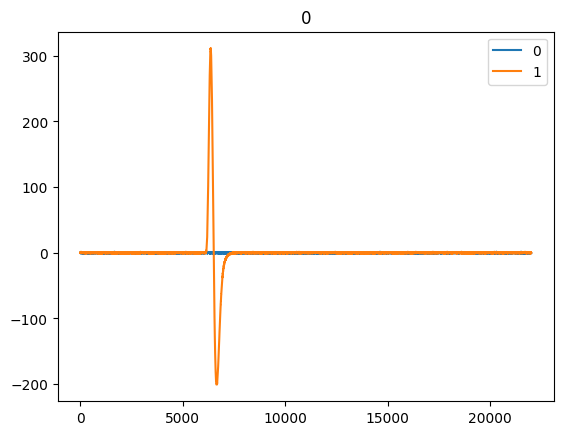

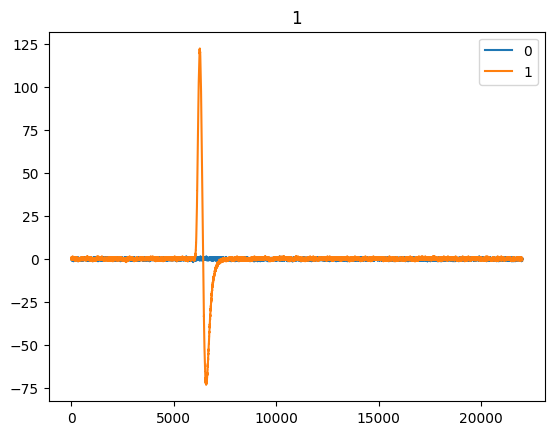

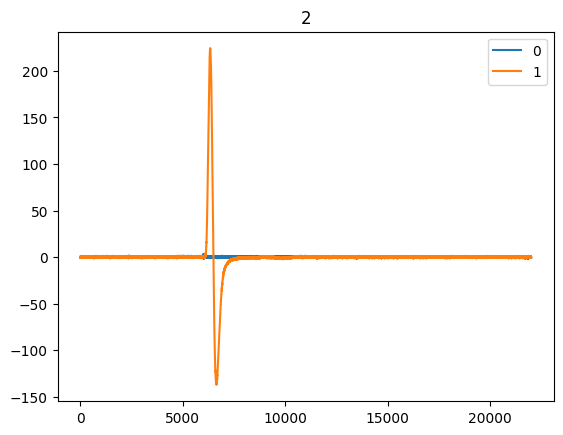

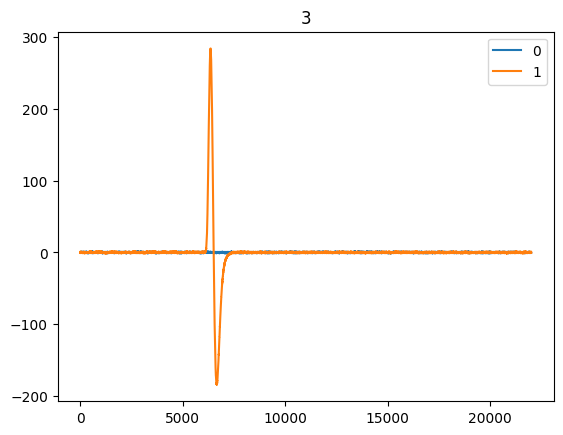

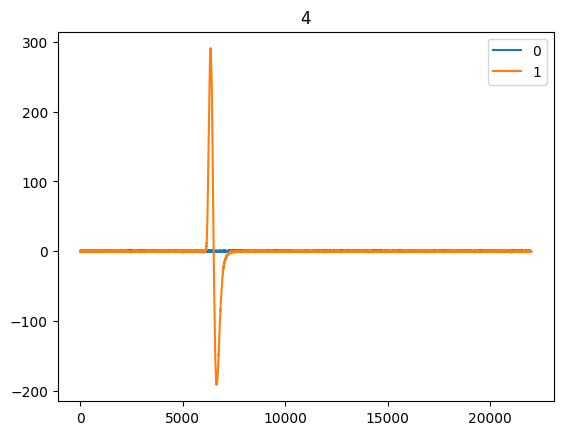

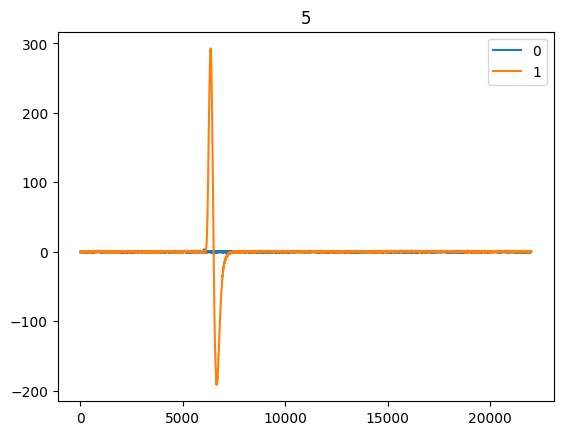

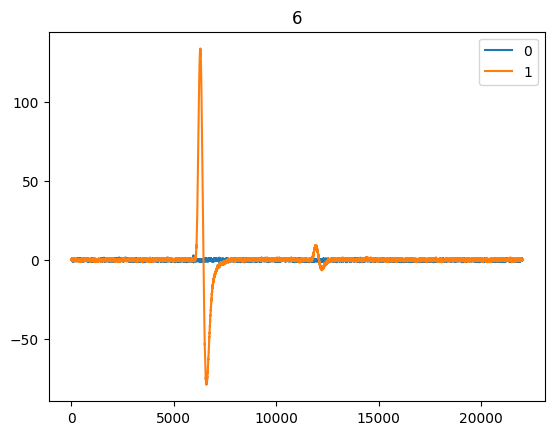

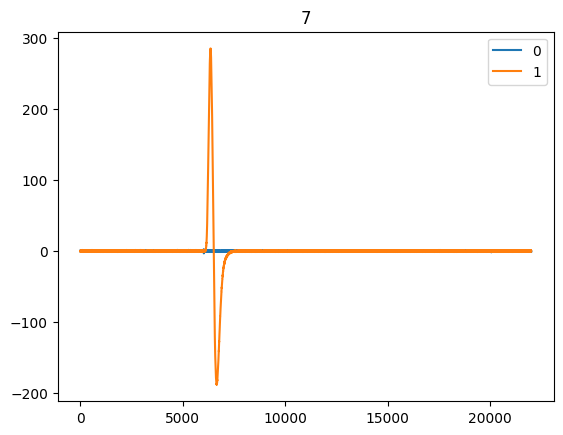

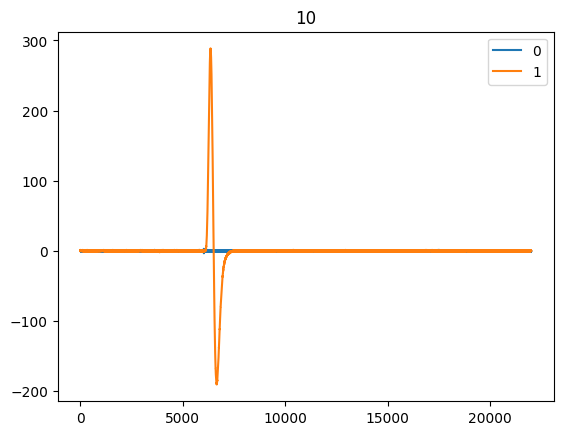

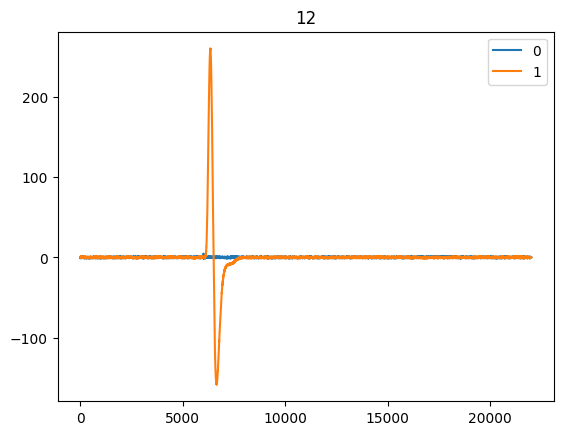

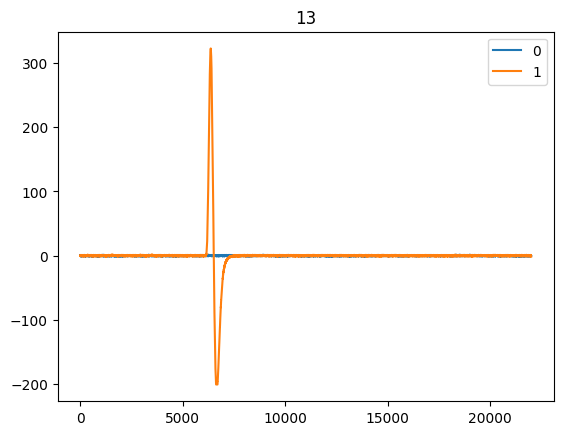

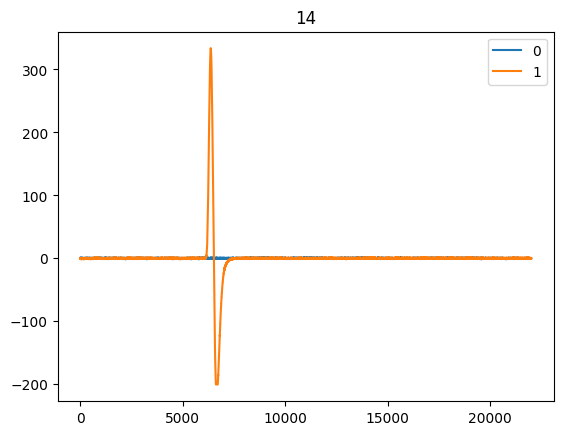

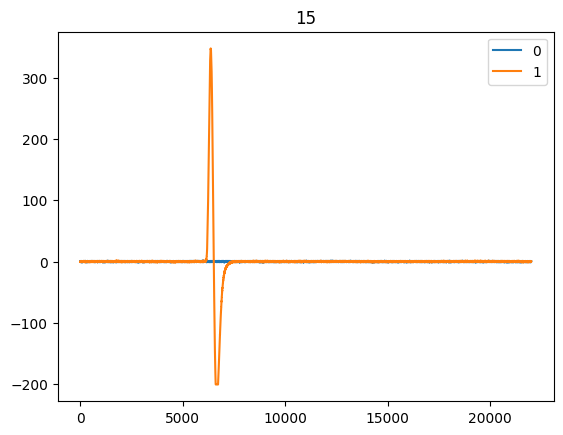

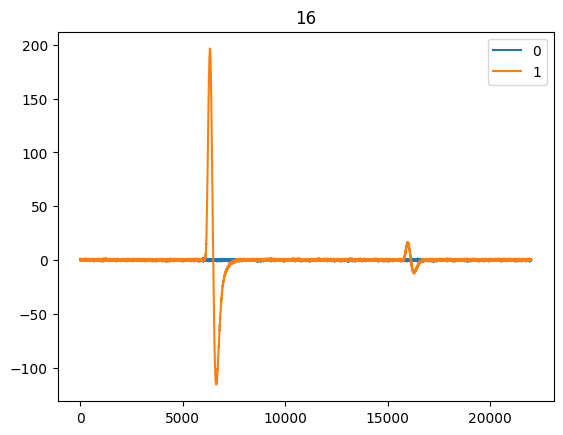

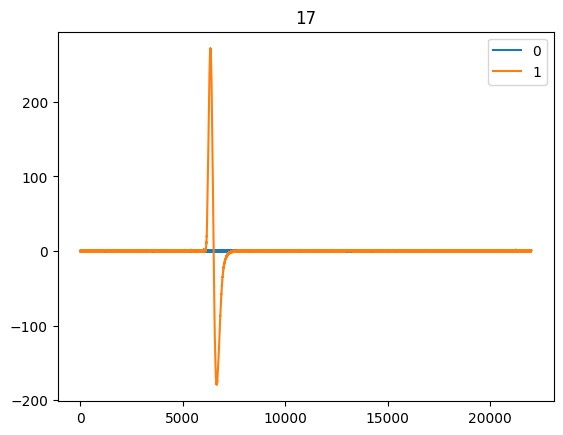

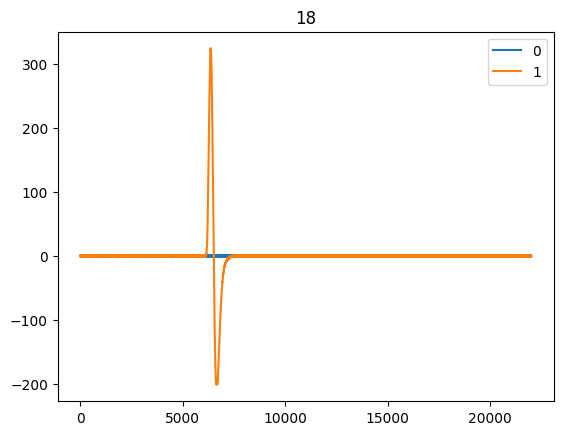

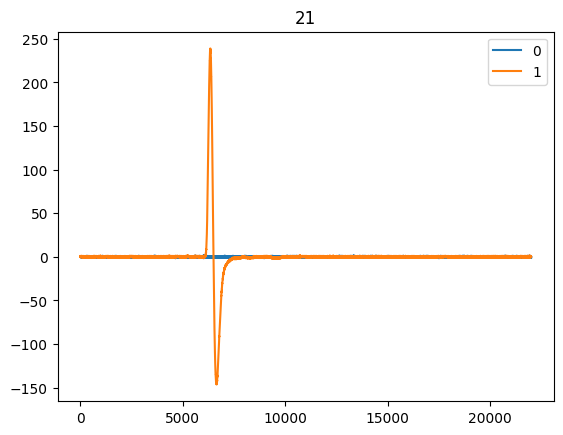

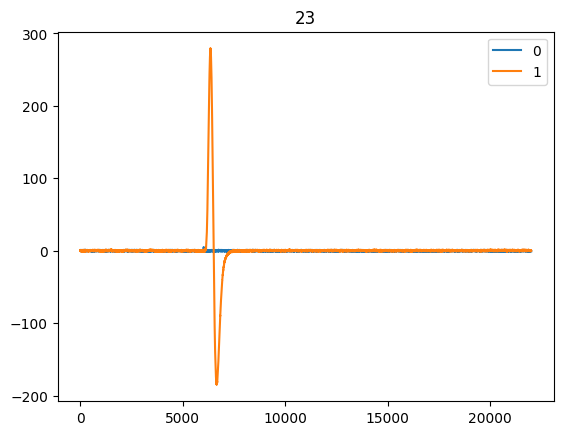

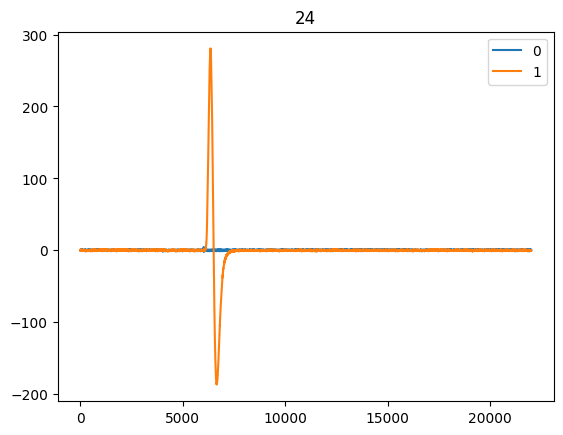

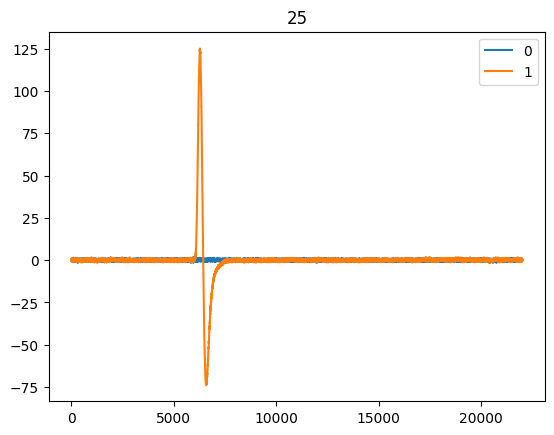

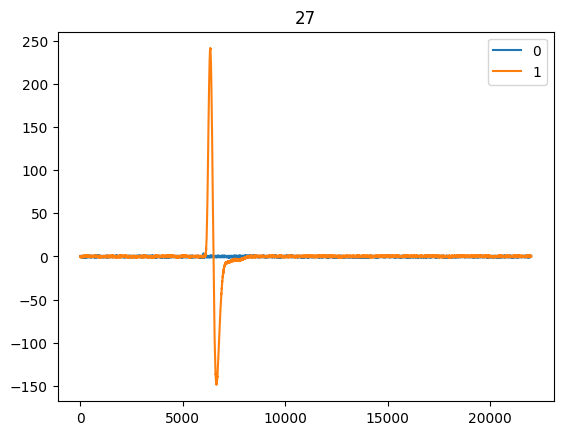

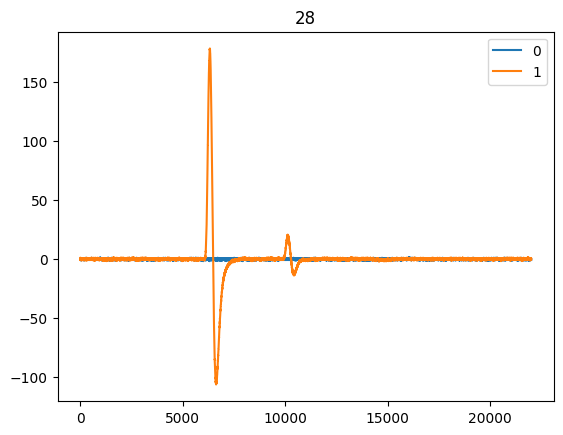

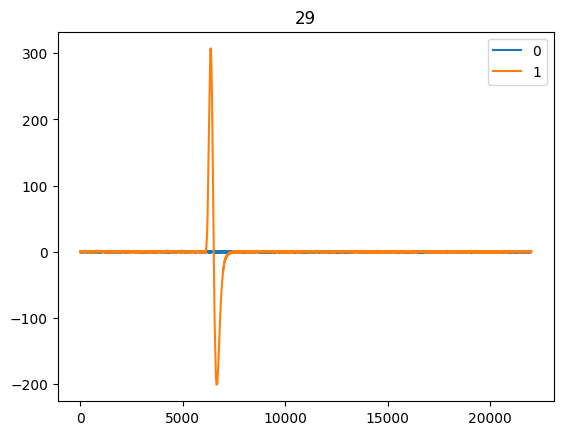

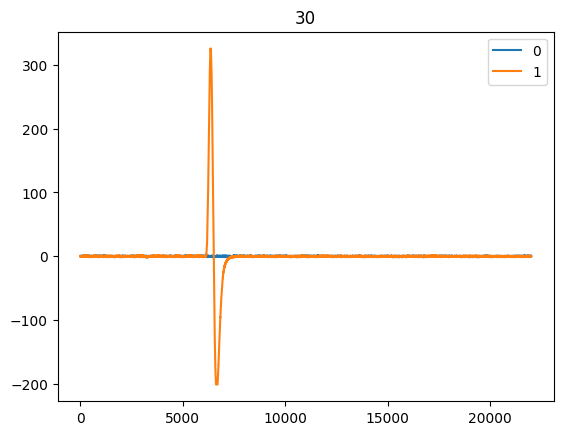

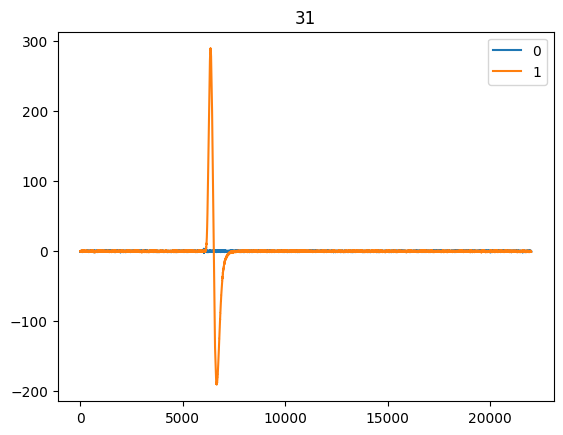

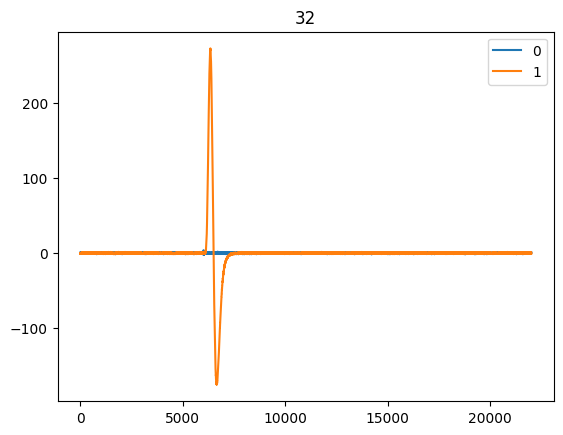

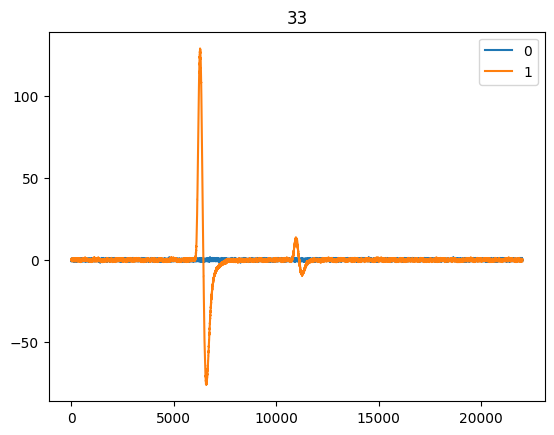

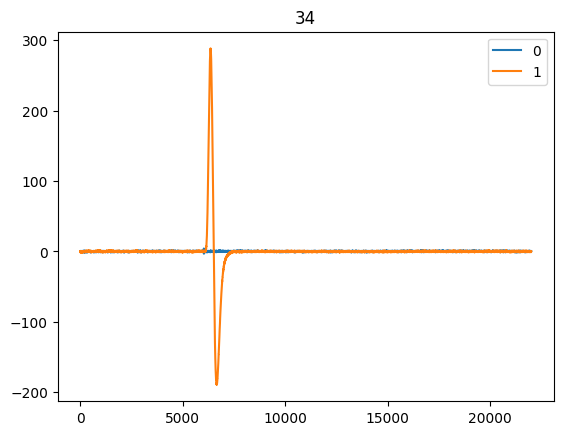

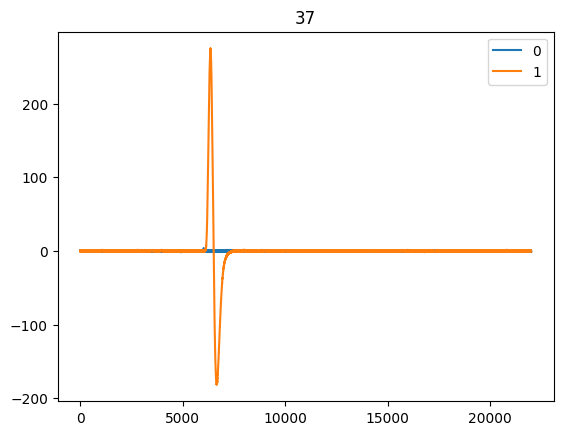

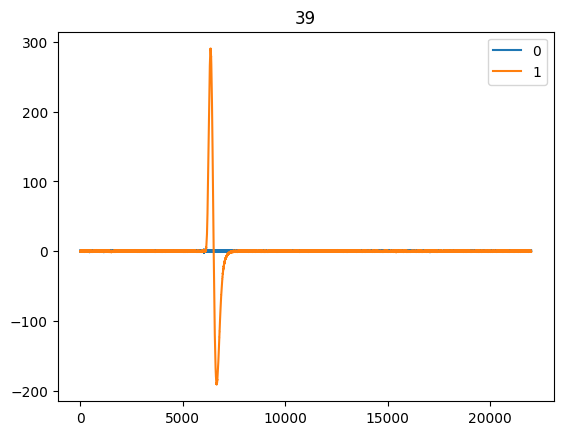

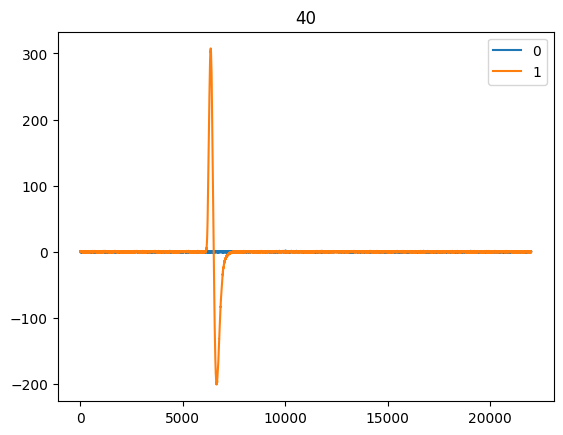

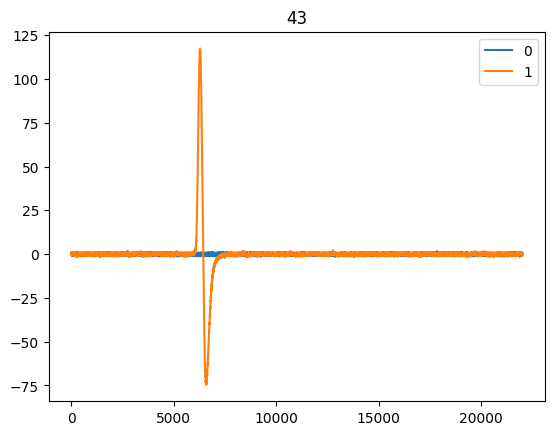

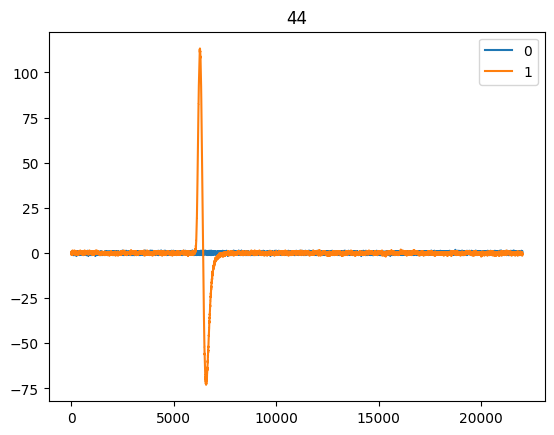

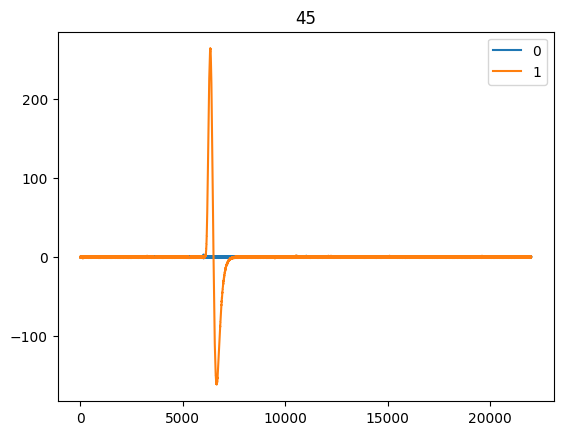

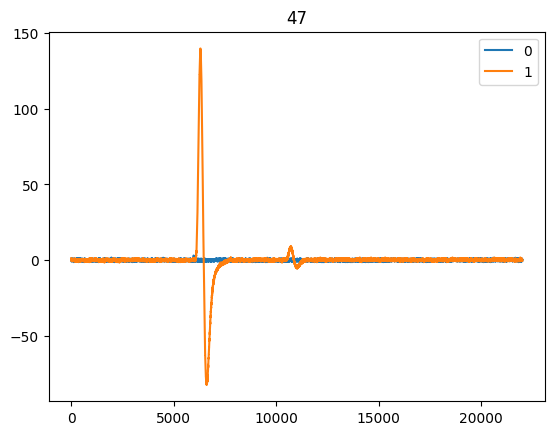

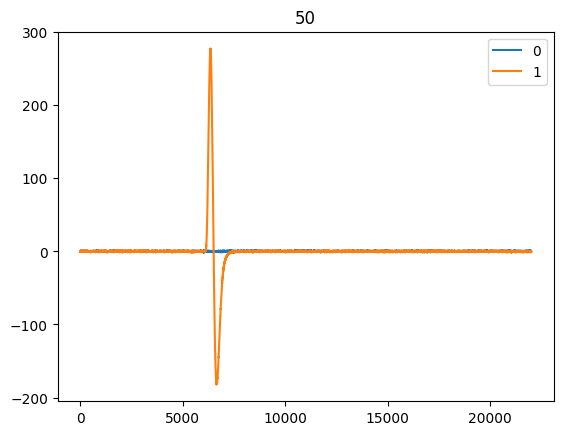

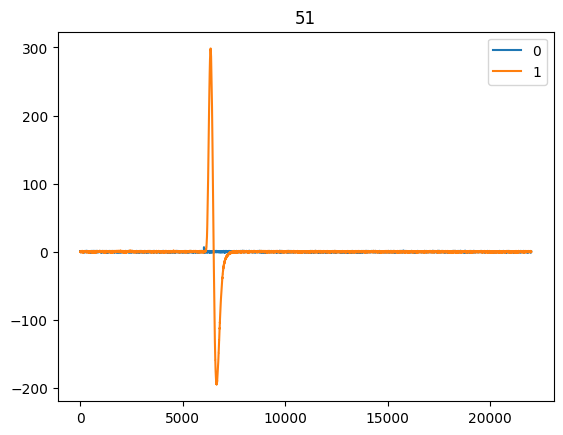

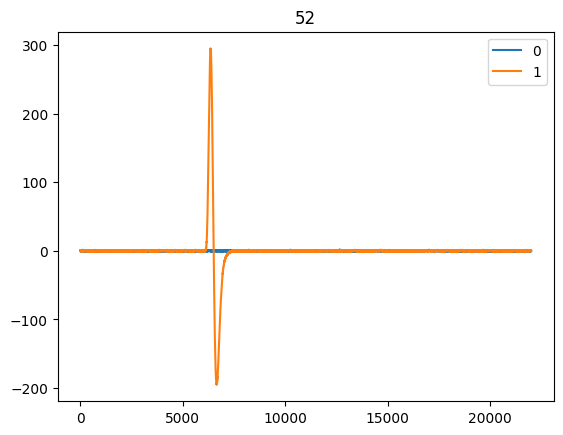

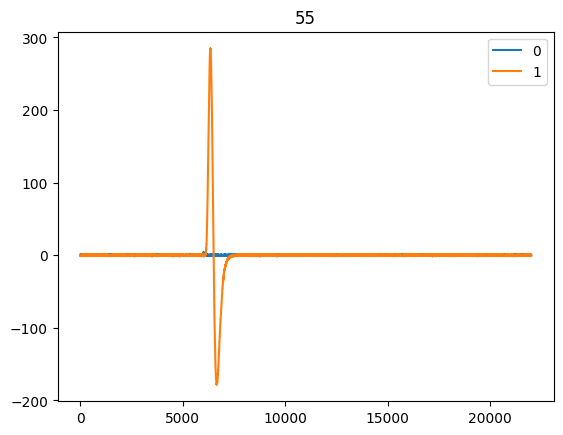

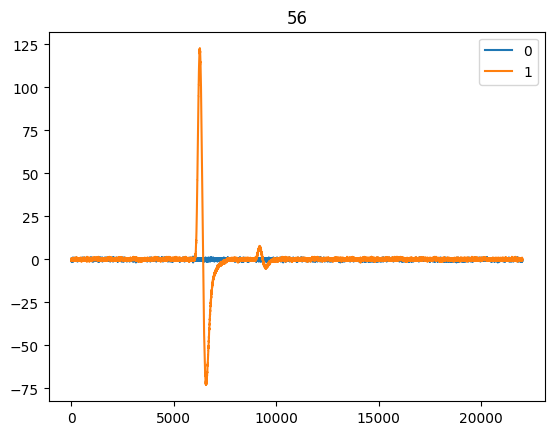

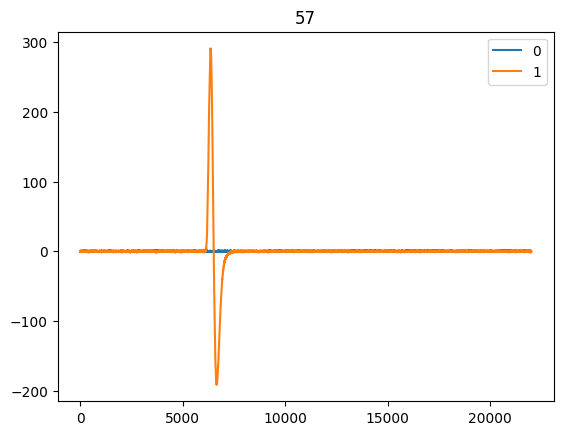

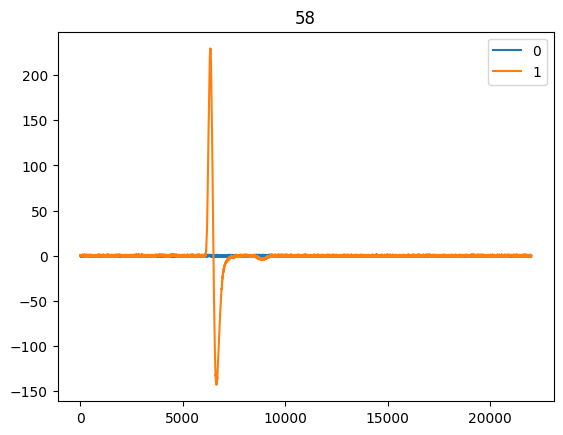

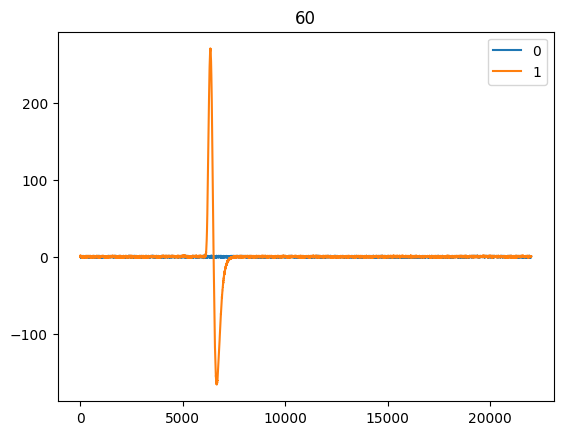

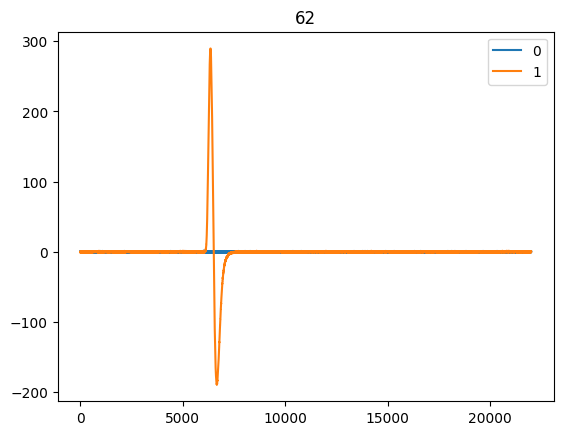

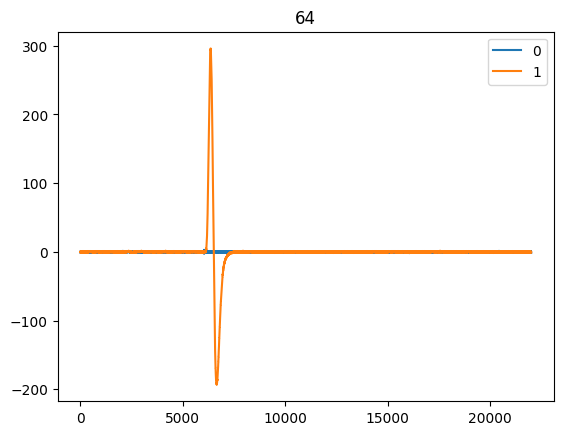

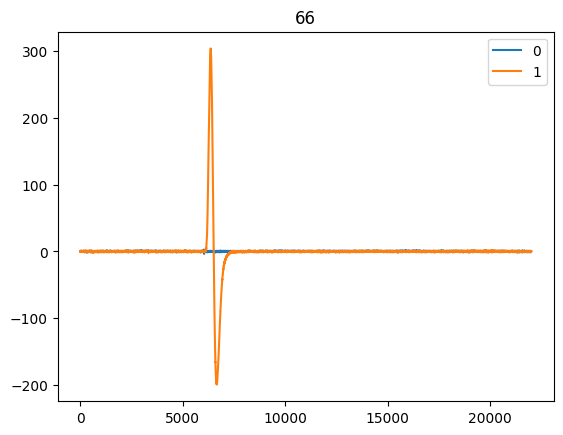

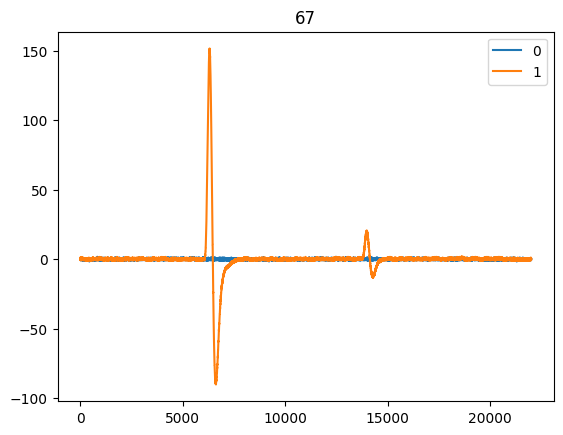

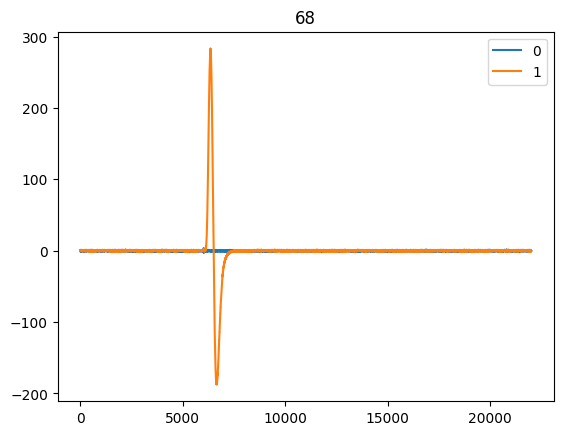

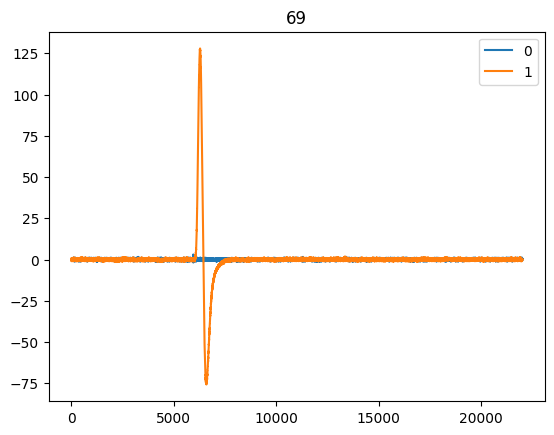

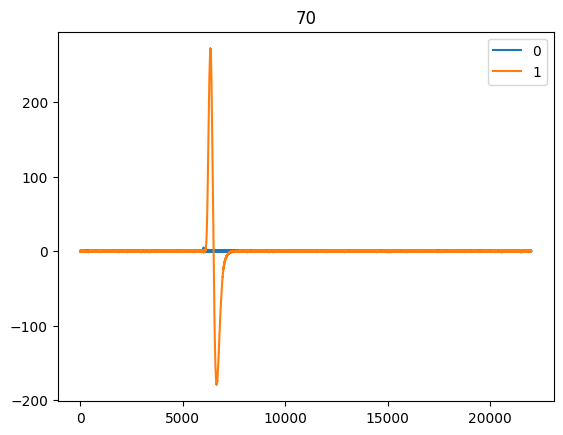

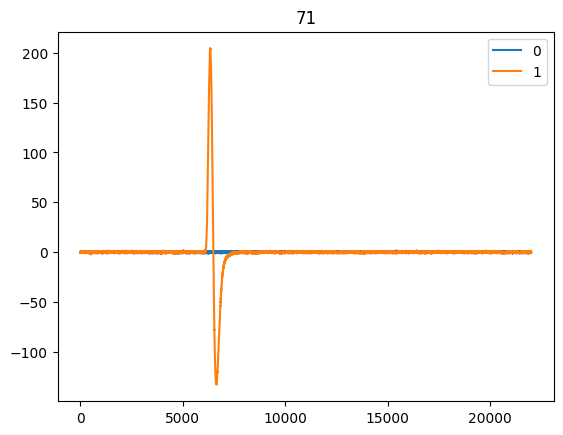

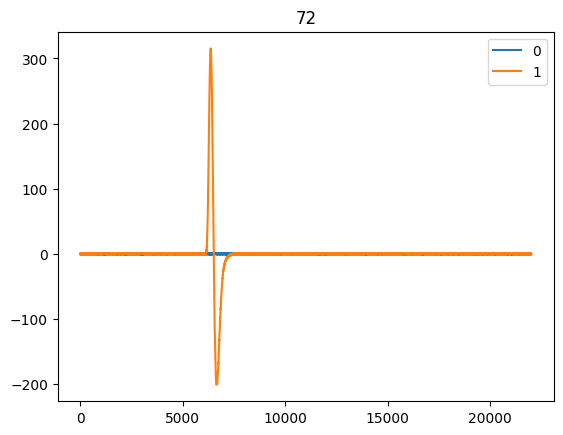

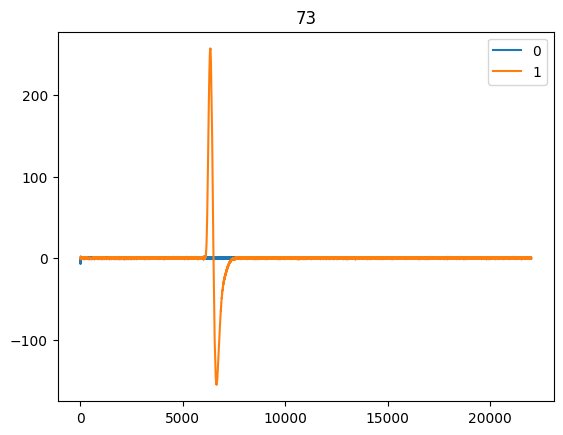

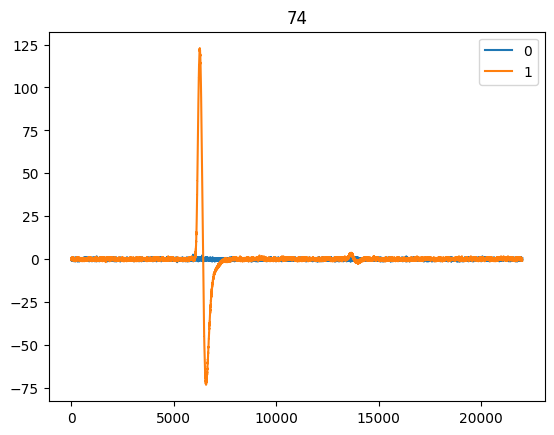

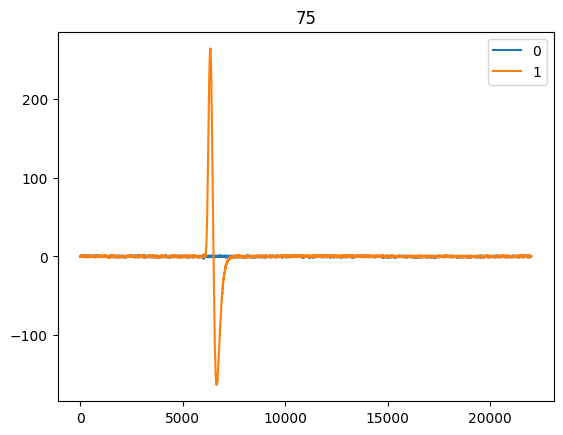

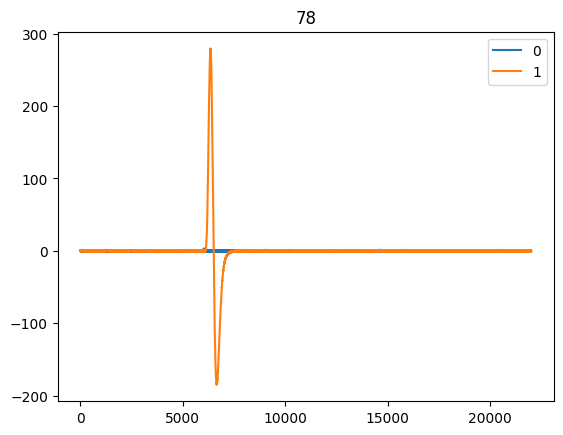

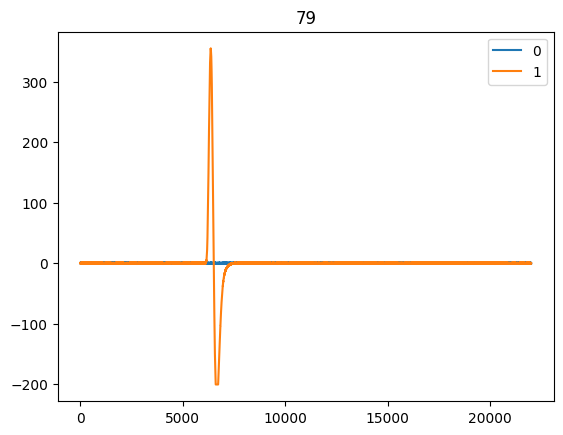

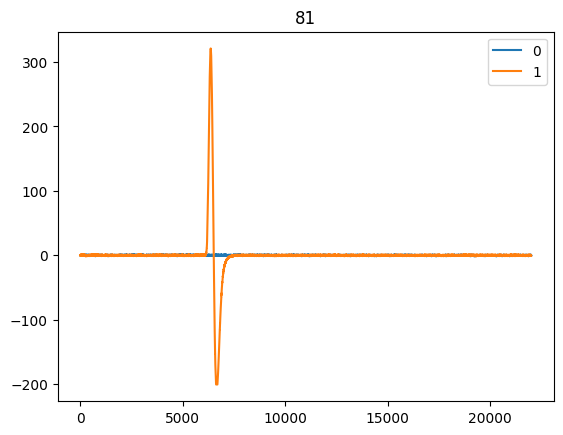

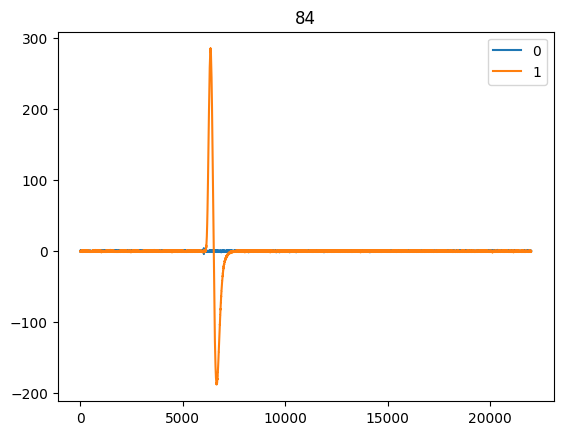

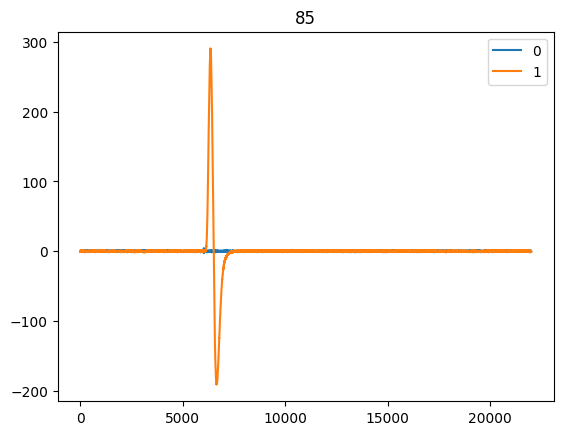

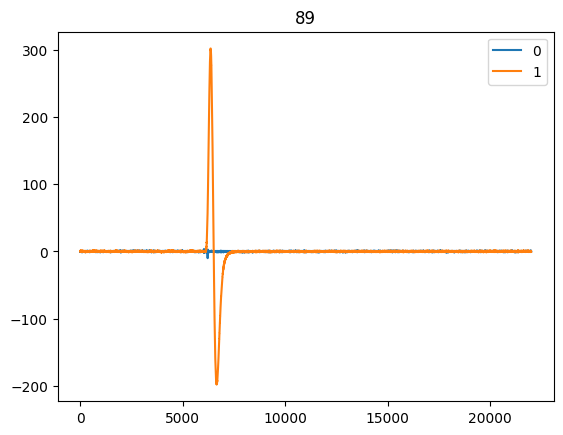

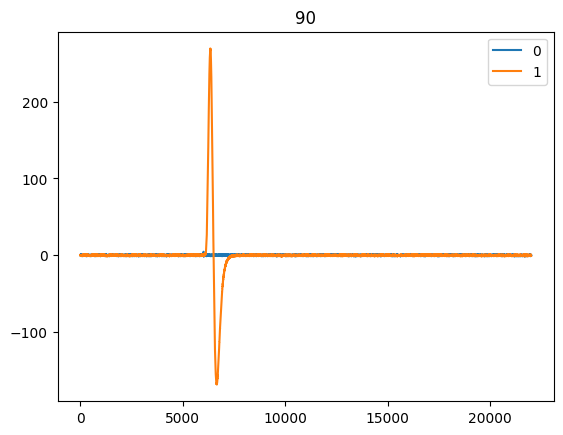

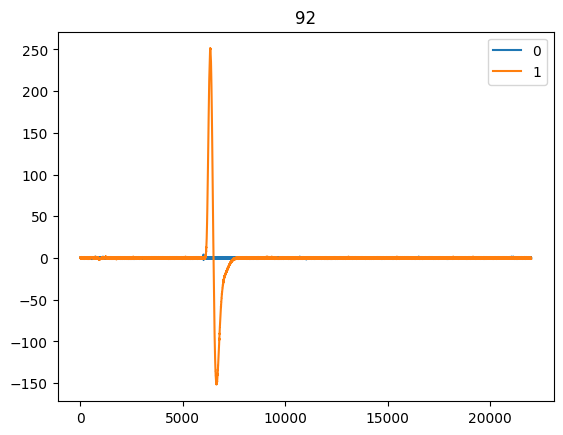

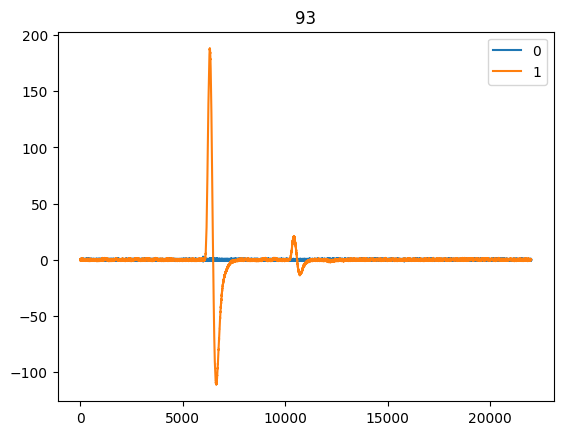

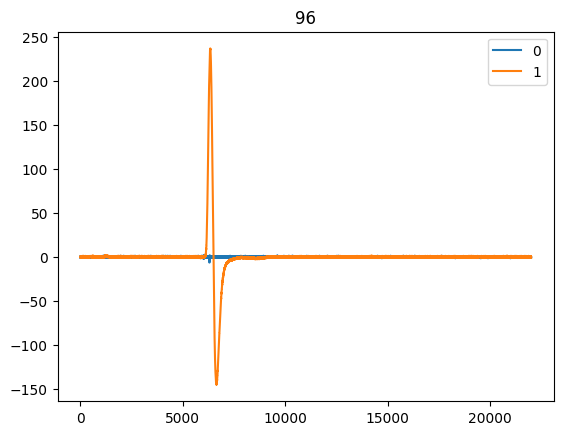

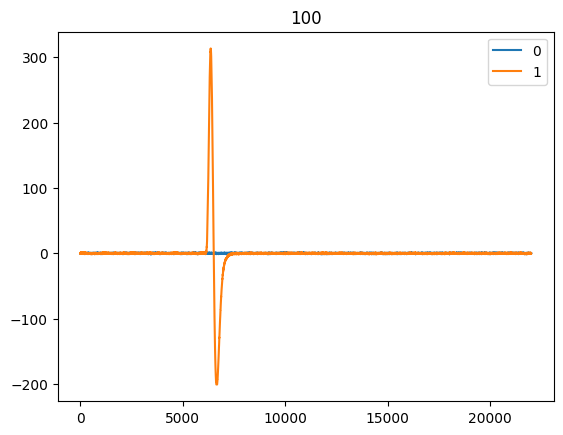

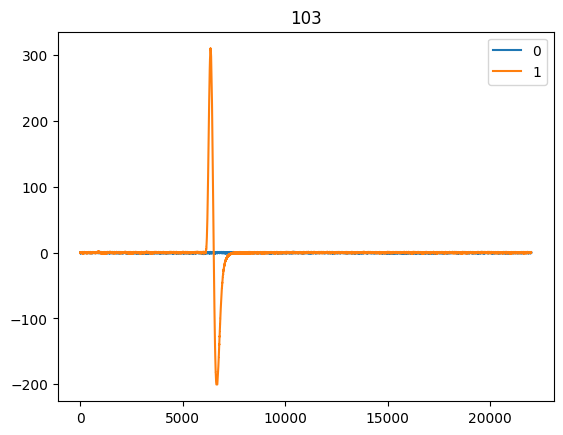

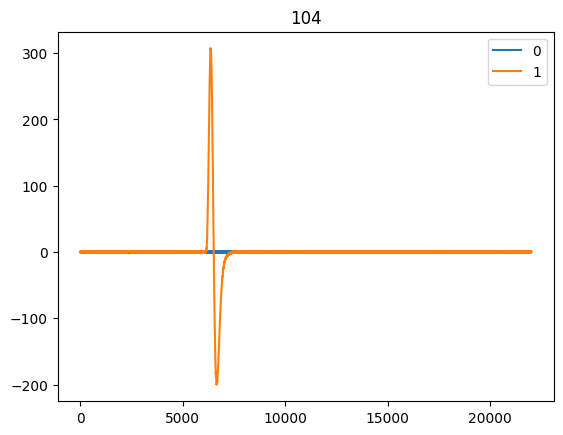

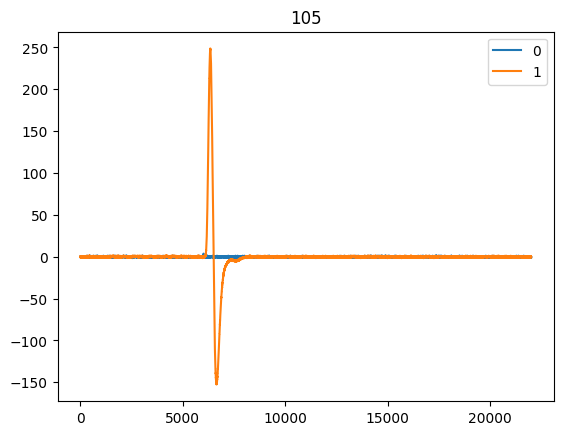

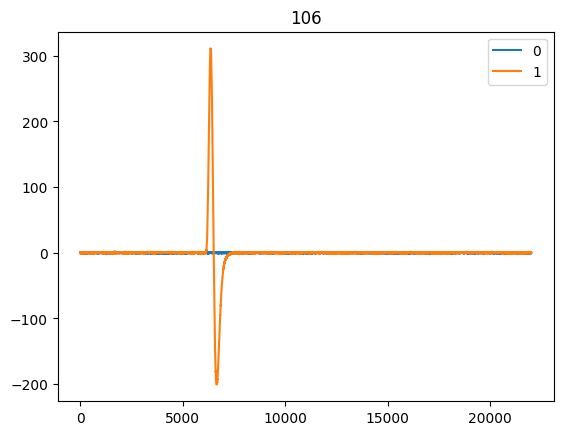

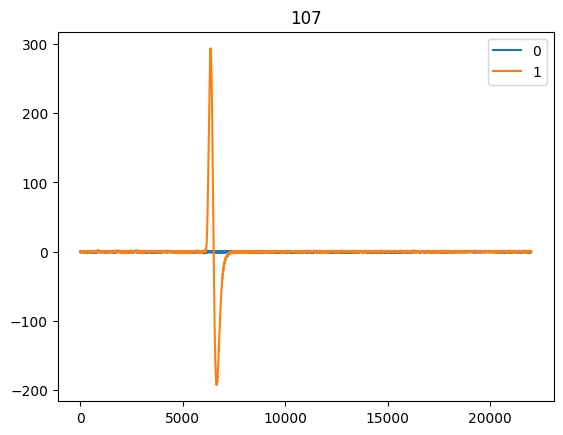

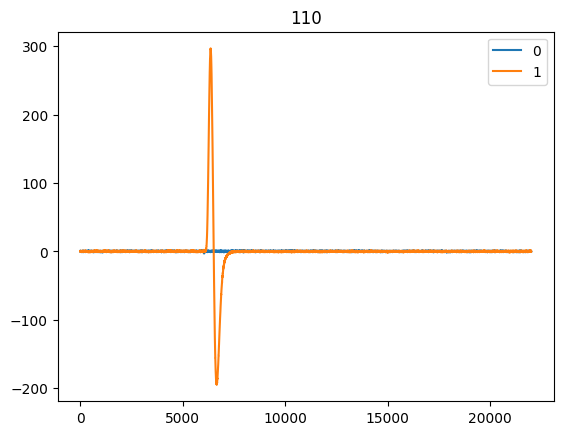

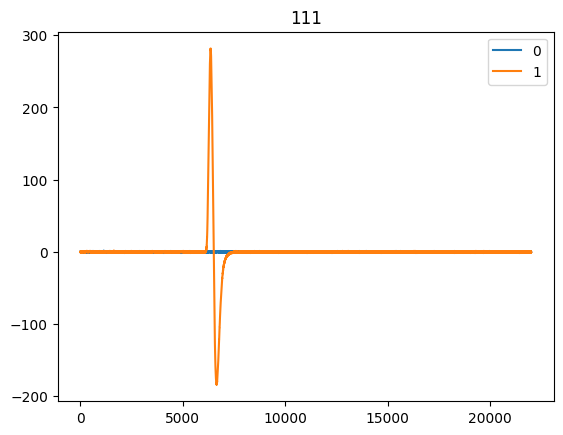

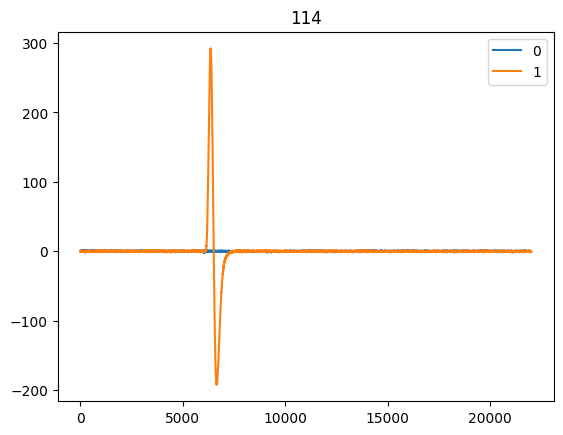

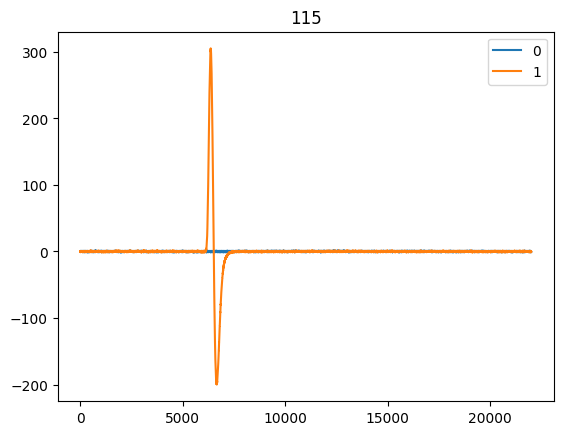

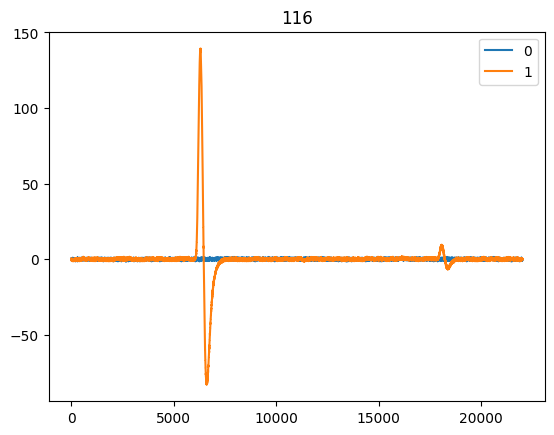

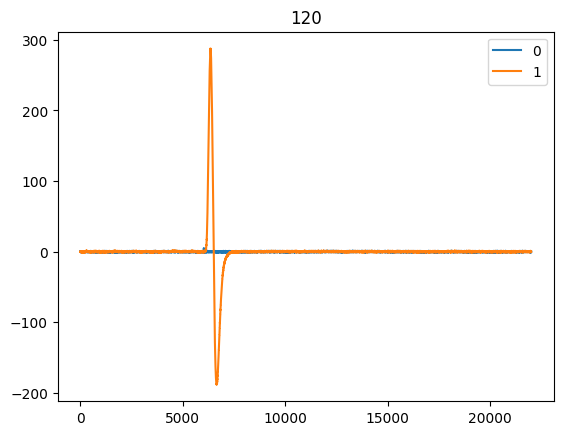

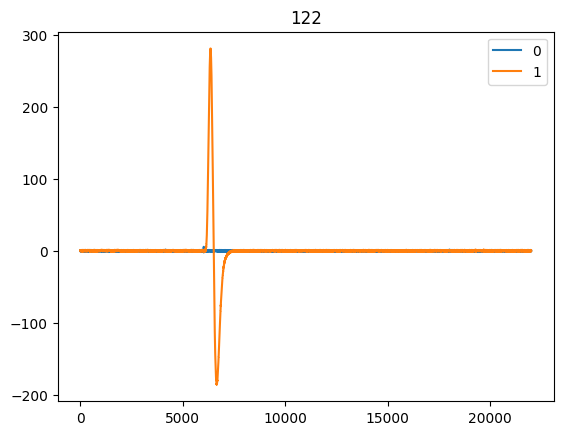

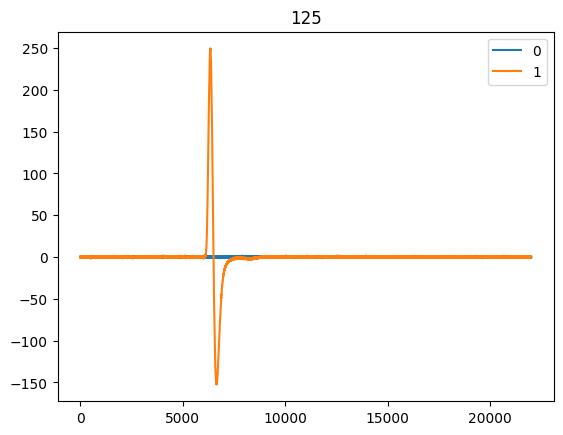

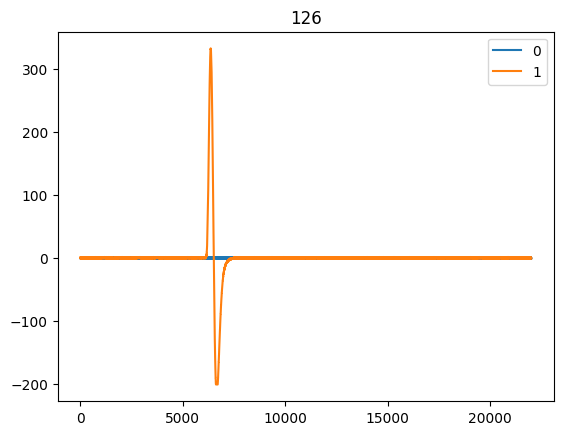

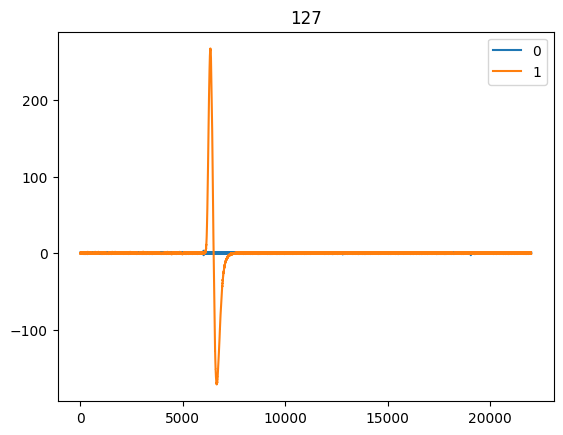

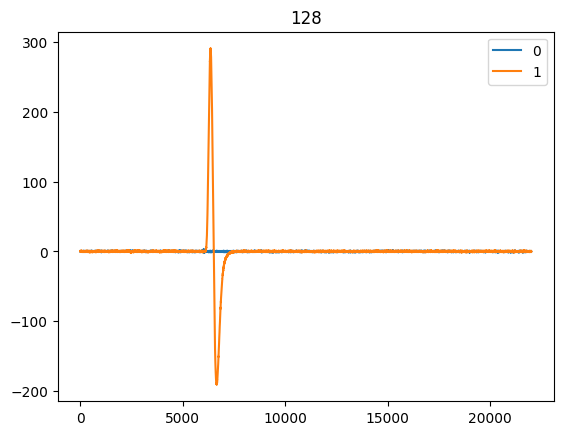

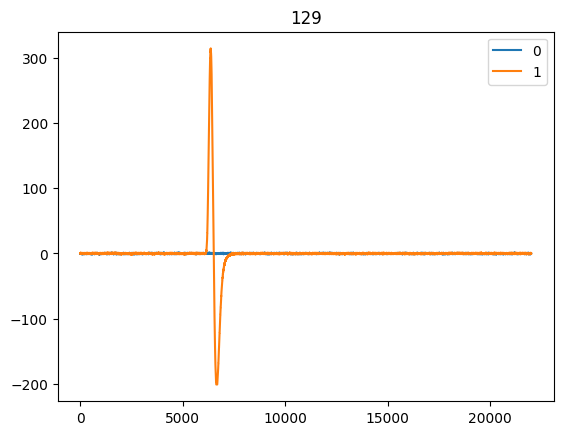

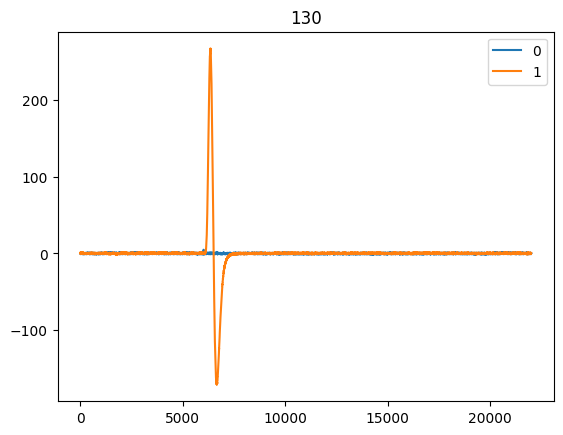

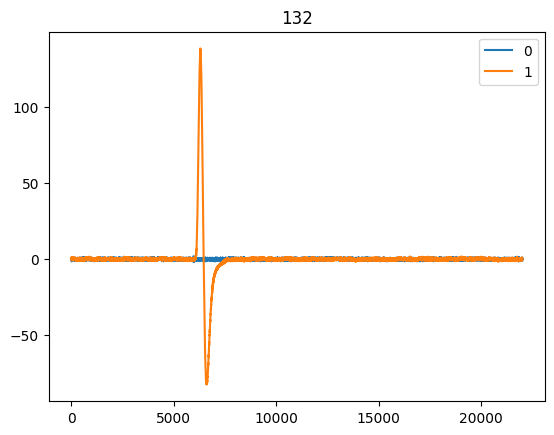

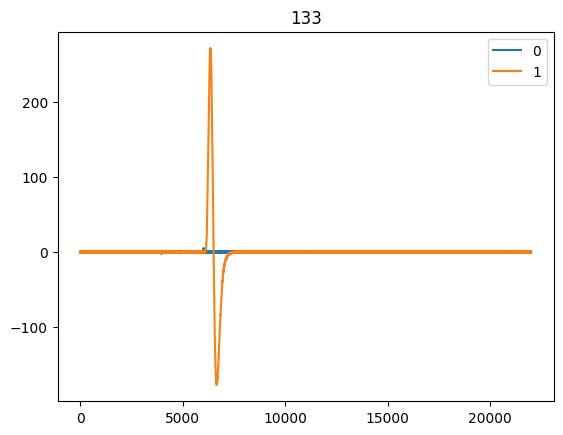

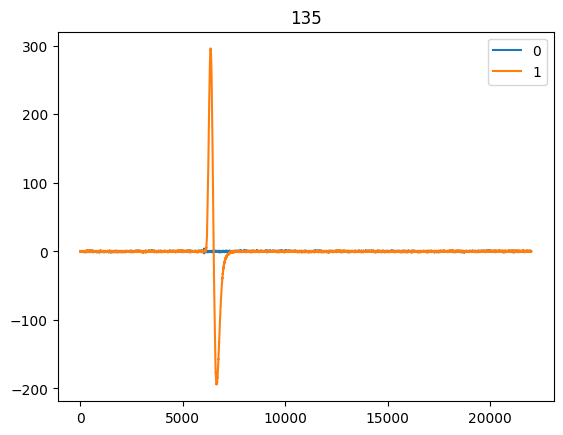

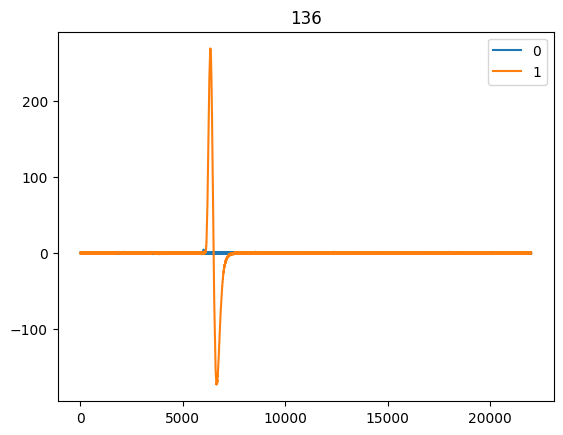

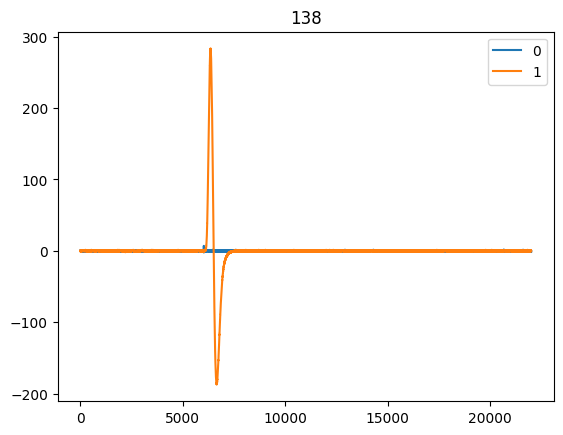

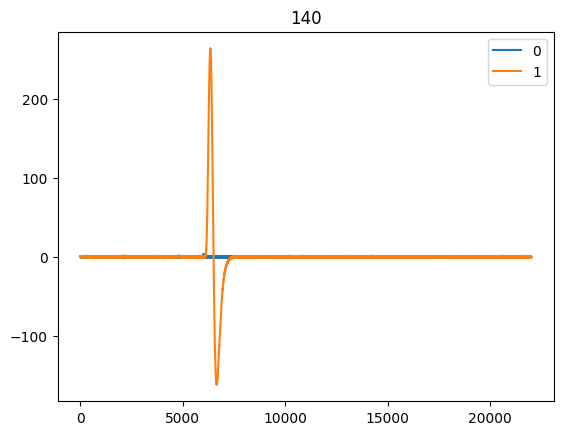

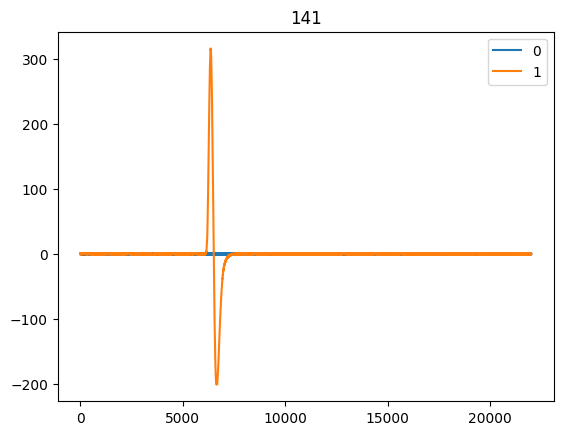

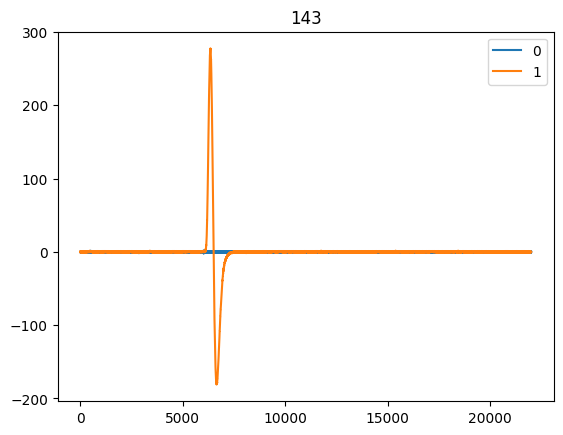

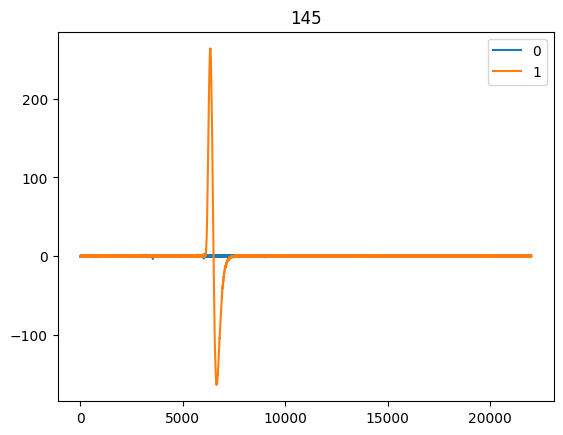

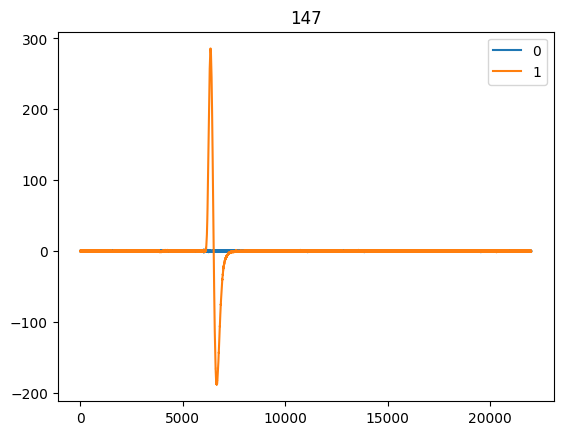

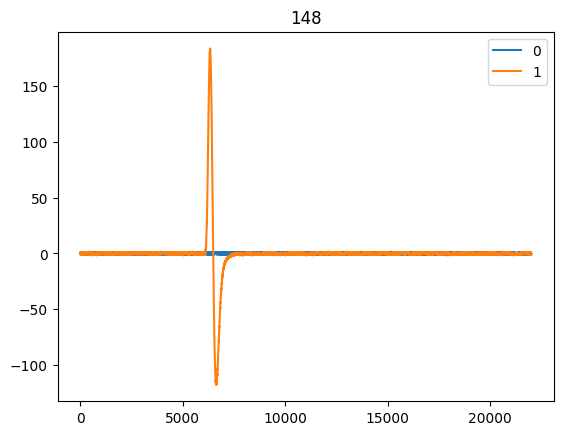

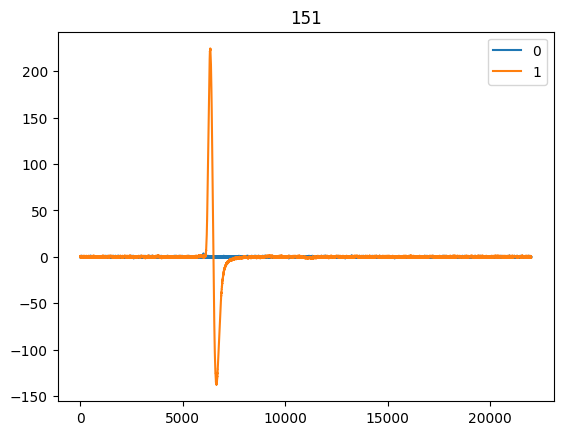

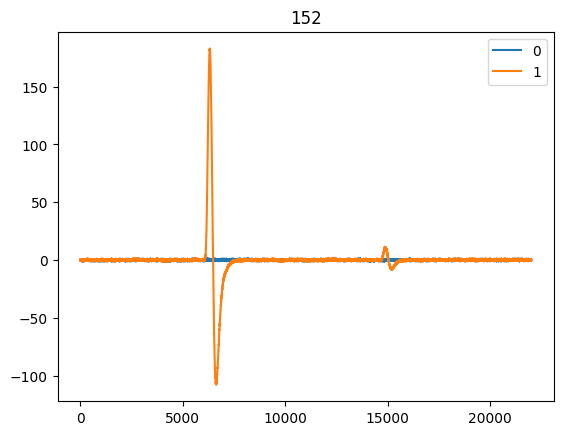

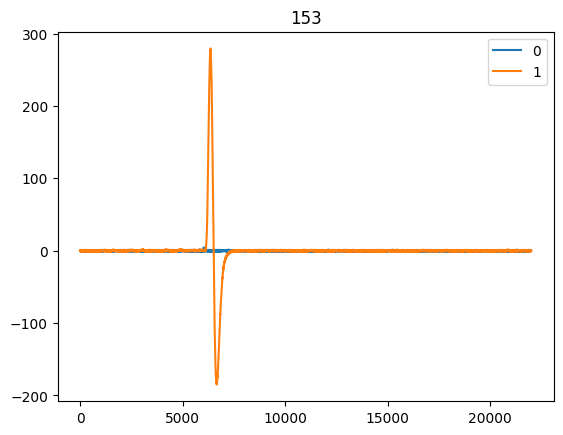

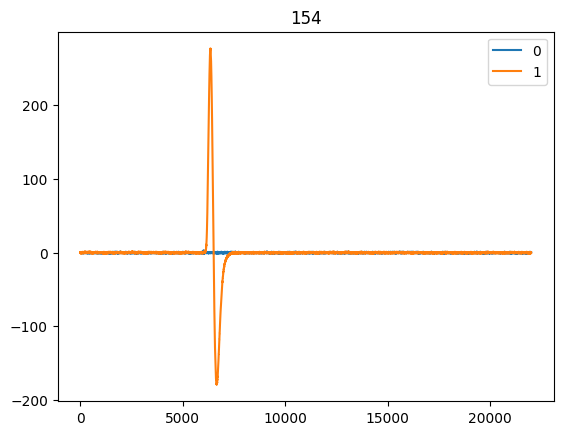

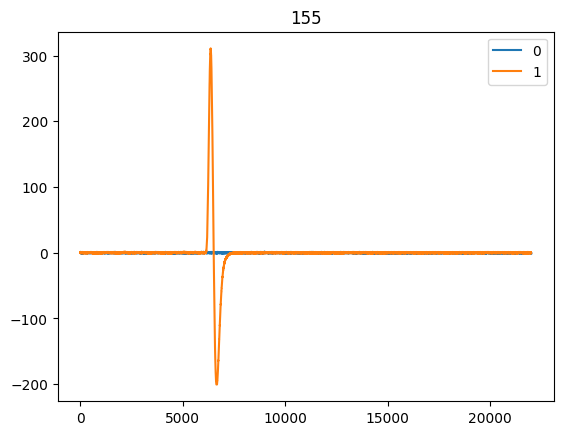

In [25]:
for event in range(100):
    if doubles[event].totalE
    for wire in range(2):
        plt.plot(range(22000), doubles[event].wfms[wire], label=wire)
    plt.legend()
    plt.title(doubles[event].eventnums[0])
    plt.show()

In [ ]:
for event in range(100):
    for wire in range(2):
        plt.plot(range(22000), singles[event].wfms[wire], label=wire)
    plt.legend()
    plt.title(singles[event].eventnums[0])
    plt.show()

In [ ]:
import pickle
# data = [[W4560, W4540, W4520, W4500, W4480, W4460],
#         [W5560, W5540, W5520, W5500, W5480, W5460],
#         [W6560, W6540, W6520, W6500, W6480, W6460],
#         [W7560, W7540, W7520, W7500, W7480, W7460],
#         [E560, E540, E520, E500, E480, E460]]

data = [[],[],[],[],[]]

file = open('../Analysis/70_30', 'wb')


# dump information to that file
pickle.dump(data, file)

# close the file
file.close()


In [ ]:
# W4520 = W4
# W5520 = W5
# W6520 = W6
# W7520 = W7
# E520 = energies2
plt.figure(figsize=(20,10))
binwidth = int(int(max(energies2)-min(energies2))/500)
#plt.hist(energies2, alpha=0.3, bins=100, label="Total")
plt.hist(W5460, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch5_460', histtype='step', density=True)
plt.hist(W5480, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch5_480', histtype='step', density=True)
plt.hist(W5500, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch5_500', histtype='step', density=True)
plt.hist(W5520, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch5_520', histtype='step', density=True)
plt.hist(W5540, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch5_540', histtype='step', density=True)
plt.hist(W5, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch5_560', histtype='step', density=True)
# plt.hist(W5460, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch5', histtype='step')
# plt.hist(W6460, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch6', histtype='step')
# plt.hist(W7460, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch7', histtype='step')
#plt.xlim(1100,1300)
plt.xlim(40,300)
# plt.yscale('log')
#plt.vlines(cut, 0, 10, colors='r')
plt.xlabel("Energy (AU)", size=20)
#plt.savefig("Ch4_spectra_voltage_progression.png")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# W4520 = W4
# W5520 = W5
# W6520 = W6
# W7520 = W7
# E520 = energies2
plt.figure(figsize=(20,10))
binwidth = int(int(max(energies2)-min(energies2))/500)
# plt.hist(energies2, alpha=0.3, bins=100, label="Total")
plt.hist(W6460, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch6_460', histtype='step', density=True)
plt.hist(W6480, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch6_480', histtype='step', density=True)
plt.hist(W6500, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch6_500', histtype='step', density=True)
plt.hist(W6520, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch6_520', histtype='step', density=True)
plt.hist(W6540, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch6_540', histtype='step', density=True)
plt.hist(W6, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch6_560', histtype='step', density=True)
# plt.hist(W5460, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch5', histtype='step')
# plt.hist(W6460, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch6', histtype='step')
# plt.hist(W7460, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch7', histtype='step')
#plt.xlim(1100,1300)
plt.xlim(40,300)
# plt.yscale('log')
#plt.vlines(cut, 0, 10, colors='r')
plt.xlabel("Energy (AU)", size=20)
#plt.savefig("Ch4_spectra_voltage_progression.png")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# W4520 = W4
# W5520 = W5
# W6520 = W6
# W7520 = W7
# E520 = energies2
plt.figure(figsize=(20,10))
binwidth = int(int(max(energies2)-min(energies2))/500)
#plt.hist(energies2, alpha=0.3, bins=100, label="Total")
plt.hist(W7460, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch7_460', histtype='step', density=True)
plt.hist(W7480, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch7_480', histtype='step', density=True)
plt.hist(W7500, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch7_500', histtype='step', density=True)
plt.hist(W7520, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch7_520', histtype='step', density=True)
plt.hist(W7540, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch7_540', histtype='step', density=True)
plt.hist(W7, bins=range(int(min(energies2)), int(max(energies2)) + binwidth, binwidth), label='Ch7_560', histtype='step', density=True)

#plt.xlim(1100,1300)
plt.xlim(40,300)
# plt.yscale('log')
#plt.vlines(cut, 0, 10, colors='r')
plt.xlabel("Energy (AU)", size=20)
#plt.savefig("Ch4_spectra_voltage_progression.png")
plt.legend(loc="upper right")
plt.show()